### Characterizing the crackle events

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.loader import loader
from GDa.util import shuffle_along_axis

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.5, 0], [0, 0.5], [0.5, 1.5], [1.5, 2.0]]

### Time-resolved rate

In [8]:
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

#### Auxiliar functions

In [9]:
def bootstrap(ts_stacked, n_trials, n_rois, n_boot):
    """
    Performs the bootstrap method on the given data.

    Parameters
    ----------
    n_boot : int
        The number of iterations for the bootstrap method
    ts_stacked : ndarray
        The time series data in stacked format
    n_trials : int
        The number of trials in the time series data
    n_rois : int
        The number of regions of interest in the time series data
    verbose : bool, optional
        Whether to print the iteration number, by default False

    Returns
    -------
    ndarray
        The bootstrapped confidence interval
    """

    ci = []
    for i in range(n_boot):
        ci += [
            np.take_along_axis(
                ts_stacked,
                np.asarray(
                    [np.random.choice(range(n_trials), n_trials) for _ in range(n_rois)]
                ),
                axis=-1,
            ).mean(-1)
        ]
    ci = np.stack(ci)
    return ci

In [10]:
def compute_median_rate(
    data: xr.DataArray,
    roi: str = None,
    thr: float = 0.95,
    stim_label: int = None,
    freqs: float = None,
    time_slice: slice = None,
    # freqs: float = None,
    n_boot: int = 100,
    n_jobs: int = 1,
    verbose: bool = False,
):
    """
    Calculates the median rate of the provided xarray DataArray, subject to optional parameters.

    Parameters:
    ----------
        data: xr.DataArray
            The input data for which the median rate is to be calculated.
        roi: str | None
            A string specifying the region of interest (ROI) to consider in the analysis.
            If None, all ROIs will be considered.
        thr: (float) | .95
            A float representing the quantile based threshold.
            Any values in 'data' less than this threshold will be set to zero.
        stim_label: int | None
            An int specifying a particular stimulus label to use in the analysis.
            If None, all stimuli will be considered.
        time_slice: slice | None
            A slice object specifying a range of times to consider in the analysis.
            If None, all times will be considered.
        freqs: float | None
            A float specifying a frequency range to use in the analysis.
            If None, all frequencies will be considered.
        n_boot: int | 100
            An int specifying the number of bootstrap resamples to use when calculating
            the median rate.
        verbose: bool | False
            When set to True, the tqdm library will be used to display a progress
            bar while the function is running.

    Returns:
    -------
        Tuple of two xarray.DataArray,
        where the first is the result of median rate calculation of the given data,
        and the second is the median rate calculated by shuffling the data along the first axis.

    """

    # Check coordinates of the DataArray
    np.testing.assert_array_equal(("roi", "freqs", "trials", "times"), data.dims)

    if isinstance(stim_label, int):
        # Get stimulus label from each trial
        stim_labels = data.stim
        # Select trials with the specific label
        idx_trials = stim_labels == stim_label
    else:
        # Otherwise get all trials
        idx_trials = [True] * data.sizes["trials"]

    # Compute quantile based threshold
    thr = data.quantile(thr, ("trials", "times"))
    # Apply threshold
    data = data >= thr
    # data = (data - data.mean("times")) / data.std("times")
    # data = data >= 3
    # Get time-series for specific trials, roi and time slice
    ts = data.sel(times=time_slice, roi=roi).isel(trials=idx_trials)

    if isinstance(freqs, (int, float)):
        freqs = [freqs]
    else:
        freqs = ts.freqs.data

    times = ts.times.data
    nfreqs, ntimes = len(freqs), len(times)

    def _for_freq(f):
        """
        Compute the bootstrapped confidence interval and surrogate time series data
        for a specific frequency band.

        Parameters:
        -----------
        f: float or int
            The specific frequency band for which to compute the confidence
            interval and surrogate time series data.

        Returns:
        --------
        ci: xr.DataArray
            The bootstrapped confidence interval, in the form of a xr.DataArray,
            with dimensions ('boot', 'times').
        surr: xr.DataArray
            The surrogate time series data, in the form of a xr.DataArray,
            with dimensions ('boot', 'times').
        """

        # Stack rois
        if "roi" in ts.dims:
            ts_stacked = ts.sel(freqs=f).stack(z=("trials", "roi")).data
        else:
            ts_stacked = ts.sel(freqs=f).data.T

        n_rois = ts_stacked.shape[0]
        n_trials = ts_stacked.shape[1]

        ci = bootstrap(ts_stacked, n_trials, n_rois, n_boot)

        surr = []
        for i in tqdm(range(n_boot)) if verbose else range(n_boot):
            surr += [shuffle_along_axis(ts_stacked, 0)]
        surr = np.stack(surr).mean(-1)
        ci = xr.DataArray(ci, dims=("boot", "times"), coords={"times": times})
        surr = xr.DataArray(surr, dims=("boot", "times"), coords={"times": times})

        return ci, surr

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute the single trial coherence
    out = parallel(p_fun(f) for f in freqs)

    ci = [out[i][0] for i in range(nfreqs)]
    surr = [out[i][1] for i in range(nfreqs)]

    ci = xr.concat(ci, "freqs").assign_coords({"freqs": freqs})
    surr = xr.concat(surr, "freqs").assign_coords({"freqs": freqs})

    return ci, surr

In [11]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

#### Single-session

In [12]:
data_loader = loader(_ROOT=_ROOT)

In [13]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)
power_fix = data_loader.load_power(**kw_loader, trial_type=2, behavioral_response=0)

In [14]:
def return_burst_prob(power, conditional=False, thr=0.95, verbose=False):
    """
    Computes the burst probability and surrogate burst probability
    for each region of interest (ROI) in the given power dataset.

    Parameters
    ----------
    power : xarray Dataset
        A multi-dimensional dataset containing the power values of
        the time-frequency representation of the time series.
    conditional : bool, optional
        Whether to compute the burst probability and surrogate burst
        probability separately for each stimulus, by default False
    thr : float, optional
        The threshold for burst detection, by default 0.95

    Returns
    -------
    tuple
        A tuple containing the burst probability and surrogate burst
        probability for each ROI, in the format (P_b, SP_b)
    """
    kw_args = dict(
        thr=thr,
        freqs=None,
        stim_label=None,
        time_slice=slice(-0.5, 2.0),
        n_boot=100,
        verbose=False,
        n_jobs=10,
    )

    trials, stim = power.trials.data, power.attrs["stim"]
    rois = np.unique(power.roi.values)

    def _for_roi():

        # Rate modulation
        P_b = []
        SP_b = []

        for roi in tqdm(rois) if verbose else rois:
            ci, surr = compute_median_rate(power, roi=roi, **kw_args)
            P_b += [ci]
            SP_b += [surr]

        P_b = xr.concat(P_b, "roi")
        P_b = P_b.assign_coords({"roi": rois})
        SP_b = xr.concat(SP_b, "roi")
        SP_b = SP_b.assign_coords({"roi": rois})

        return P_b, SP_b

    if not conditional:
        return _for_roi()
    else:
        # Stimulus dependent rate modulation
        P_b_stim = []
        SP_b_stim = []
        for stim in tqdm(range(1, 6)) if verbose else range(1, 6):
            kw_args["stim_label"] = stim
            P_b, SP_b = _for_roi()

            P_b_stim += [P_b]
            SP_b_stim += [SP_b]
        P_b_stim = xr.concat(P_b_stim, "stim")
        SP_b_stim = xr.concat(SP_b_stim, "stim")

        return P_b_stim, SP_b_stim

In [72]:
# Computes burst probability for task and fixation
P_b_task, SP_b_task = return_burst_prob(power_task, thr=0.95)
P_b_fix, SP_b_fix = return_burst_prob(power_fix, thr=0.95)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

In [73]:
# Computes burst probability for task and fixation
P_b_task_stim, SP_b_task_stim = return_burst_prob(
    power_task, conditional=True, thr=0.95
)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

In [74]:
def cluster_burst_prob(data, n_components, ksize=None, seed=0, n_jobs=1, verbose=False):
    """
    cluster_burst_prob - function to perform KMeans clustering and Non-negative matrix
    factorization (NMF) on input data with parallel computing.

    Parameters:
    data (xr.DataArray): input data with dimensions roi, freqs, boot, times
    n_components (int): number of clusters for KMeans and NMF
    seed (int, optional): seed for random number generator (default 0)
    n_jobs (int, optional): number of jobs for parallel computing (default 1)
    verbose (bool, optional): flag for verbose output (default False)

    Returns:
    W (xr.DataArray): data array for the features of KMeans
    H (xr.DataArray): data array for the components of NMF
    labels (xr.DataArray): data array for the labels of KMeans

    """
    np.testing.assert_array_equal(data.dims, ("roi", "freqs", "boot", "times"))

    rois, freqs, times = data.roi.data, data.freqs.data, data.times.data

    nfreqs = len(freqs)

    X = data.median("boot")

    def _for_freq(f):

        X_ = X.sel(freqs=f)

        # Perform KMeans clustering
        labels = (
            KMeans(n_clusters=n_components, random_state=seed, init="random")
            .fit(X_.data)
            .labels_
        )

        # NNTF
        nmf = NMF(
            n_components=n_components, init="random", random_state=seed, max_iter=1000
        )
        W = nmf.fit_transform(X_.data)
        H = nmf.components_

        times = X_.times.data.astype(np.float32)

        return W, H, labels

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute the single trial coherence
    out = parallel(p_fun(f) for f in freqs)

    # Unpacking outputs
    W = np.stack([out[i][0] for i in range(nfreqs)], 1)
    H = np.stack([out[i][1] for i in range(nfreqs)], 1)
    labels = np.stack([out[i][2] for i in range(nfreqs)], 1)

    if isinstance(ksize, int):
        kernel = np.ones(ksize) / ksize
        H = fftconvolve(H, kernel[np.newaxis, np.newaxis, ...], mode="same", axes=2)

    # Convert to DataArray
    W = xr.DataArray(
        W, dims=("roi", "freqs", "components"), coords=dict(roi=rois, freqs=freqs)
    )

    H = xr.DataArray(
        H, dims=("components", "freqs", "times"), coords=dict(times=times, freqs=freqs)
    )

    labels = xr.DataArray(
        labels, dims=("roi", "freqs"), coords=dict(roi=rois, freqs=freqs)
    )

    return W, H, labels

In [75]:
W_task, H_task, labels_task = cluster_burst_prob(
    P_b_task, 4, ksize=3, seed=0, n_jobs=10
)
W_fix, H_fix, labels_fix = cluster_burst_prob(P_b_fix, 4, ksize=3, seed=0, n_jobs=10)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

In [76]:
def plot_rate_probability(
    X, labels, ax, vmax=None, cmap="turbo", colors=["r", "b", "g", "m"]
):
    """
    Plot a rate probability heatmap of the data X, highlighting different regions in different colors.

    Parameters:
    - X (xarray.DataArray): The data array to be plotted. Should have dimensions ('roi', 'times')
    - labels (xarray.DataArray): An array of labels for each region of interest. Should have dimension 'roi'.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axes object to use for the plot.
    - vmax (float, optional): The maximum value for the color scale. If None, it defaults to the maximum value of the data.
    - colors (list, optional): A list of color codes to use for the different labels. Default is ["r", "b", "g", "m"].

    Returns:
    - None
    """
    plt.sca(ax)

    rois, times = X.roi.data, X.times.data
    nrois, ntimes = len(rois), len(times)
    labels = np.asarray(labels.sel(roi=X.roi))

    idx = np.argsort(labels).data
    print(idx)

    plt.imshow(
        X.data[idx, :], aspect="auto", cmap=cmap, origin="lower", vmin=0, vmax=vmax
    )
    cbar = plt.colorbar(extend="max")
    cbar.ax.set_ylabel(r"$P_c[t]$", rotation=90, fontsize=10)
    x_ticks_idx = ax.get_xticks()[1:-1].astype(int)

    tks = plt.yticks(range(nrois), rois[idx])
    [tks[1][i].set_color(colors[labels[idx][i]]) for i in range(nrois)]
    plt.xlabel("Time [s]", fontsize=12)

    refs = np.asarray([np.abs(t - times).argmin() for t in [0, 0.5, 1.5]])
    plt.xticks(refs, [0, 0.5, 1.5])

    [ax.axvline(refs[i], -0.1, nrois - 1, color="k", ls="--") for i in range(3)]


def plot_embedding(W, labels, ax, names=True, colors=["r", "b", "g", "m"]):
    """
    Plot a 2D embedding of data W, highlighting different regions in different colors.

    Parameters:
    - W (np.ndarray): The data array to be plotted. Should have shape (num_roi, feature_dim)
    - labels (xarray.DataArray): An array of labels for each region of interest. Should have dimension 'roi'.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axes object to use for the plot.
    - names (bool, optional): Whether to show the names of each point in the plot or not. Default is True
    - colors (list, optional): A list of color codes to use for the different labels. Default is ["r", "b", "g", "m"].

    Returns:
    - None
    """
    plt.sca(ax)

    labels = np.asarray(labels.sel(roi=W.roi)).data
    rois = W.roi.data
    nrois = len(rois)

    X_embedded = umap.UMAP(n_neighbors=5, min_dist=1, random_state=20).fit_transform(W)

    for i in range(len(X_embedded)):
        plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[labels[i]])
    if names:
        for i in range(len(X_embedded)):
            plt.text(X_embedded[i, 0] + 0.1, X_embedded[i, 1] + 0.1, rois[i])
    plt.xticks([])
    plt.yticks([])
    [ax.spines[key].set_visible(False) for key in ax.spines.keys()]

In [88]:
vmax = [0.1] * 10  # [0.2] * 3 + [.15] * 3 + [.1] * 4

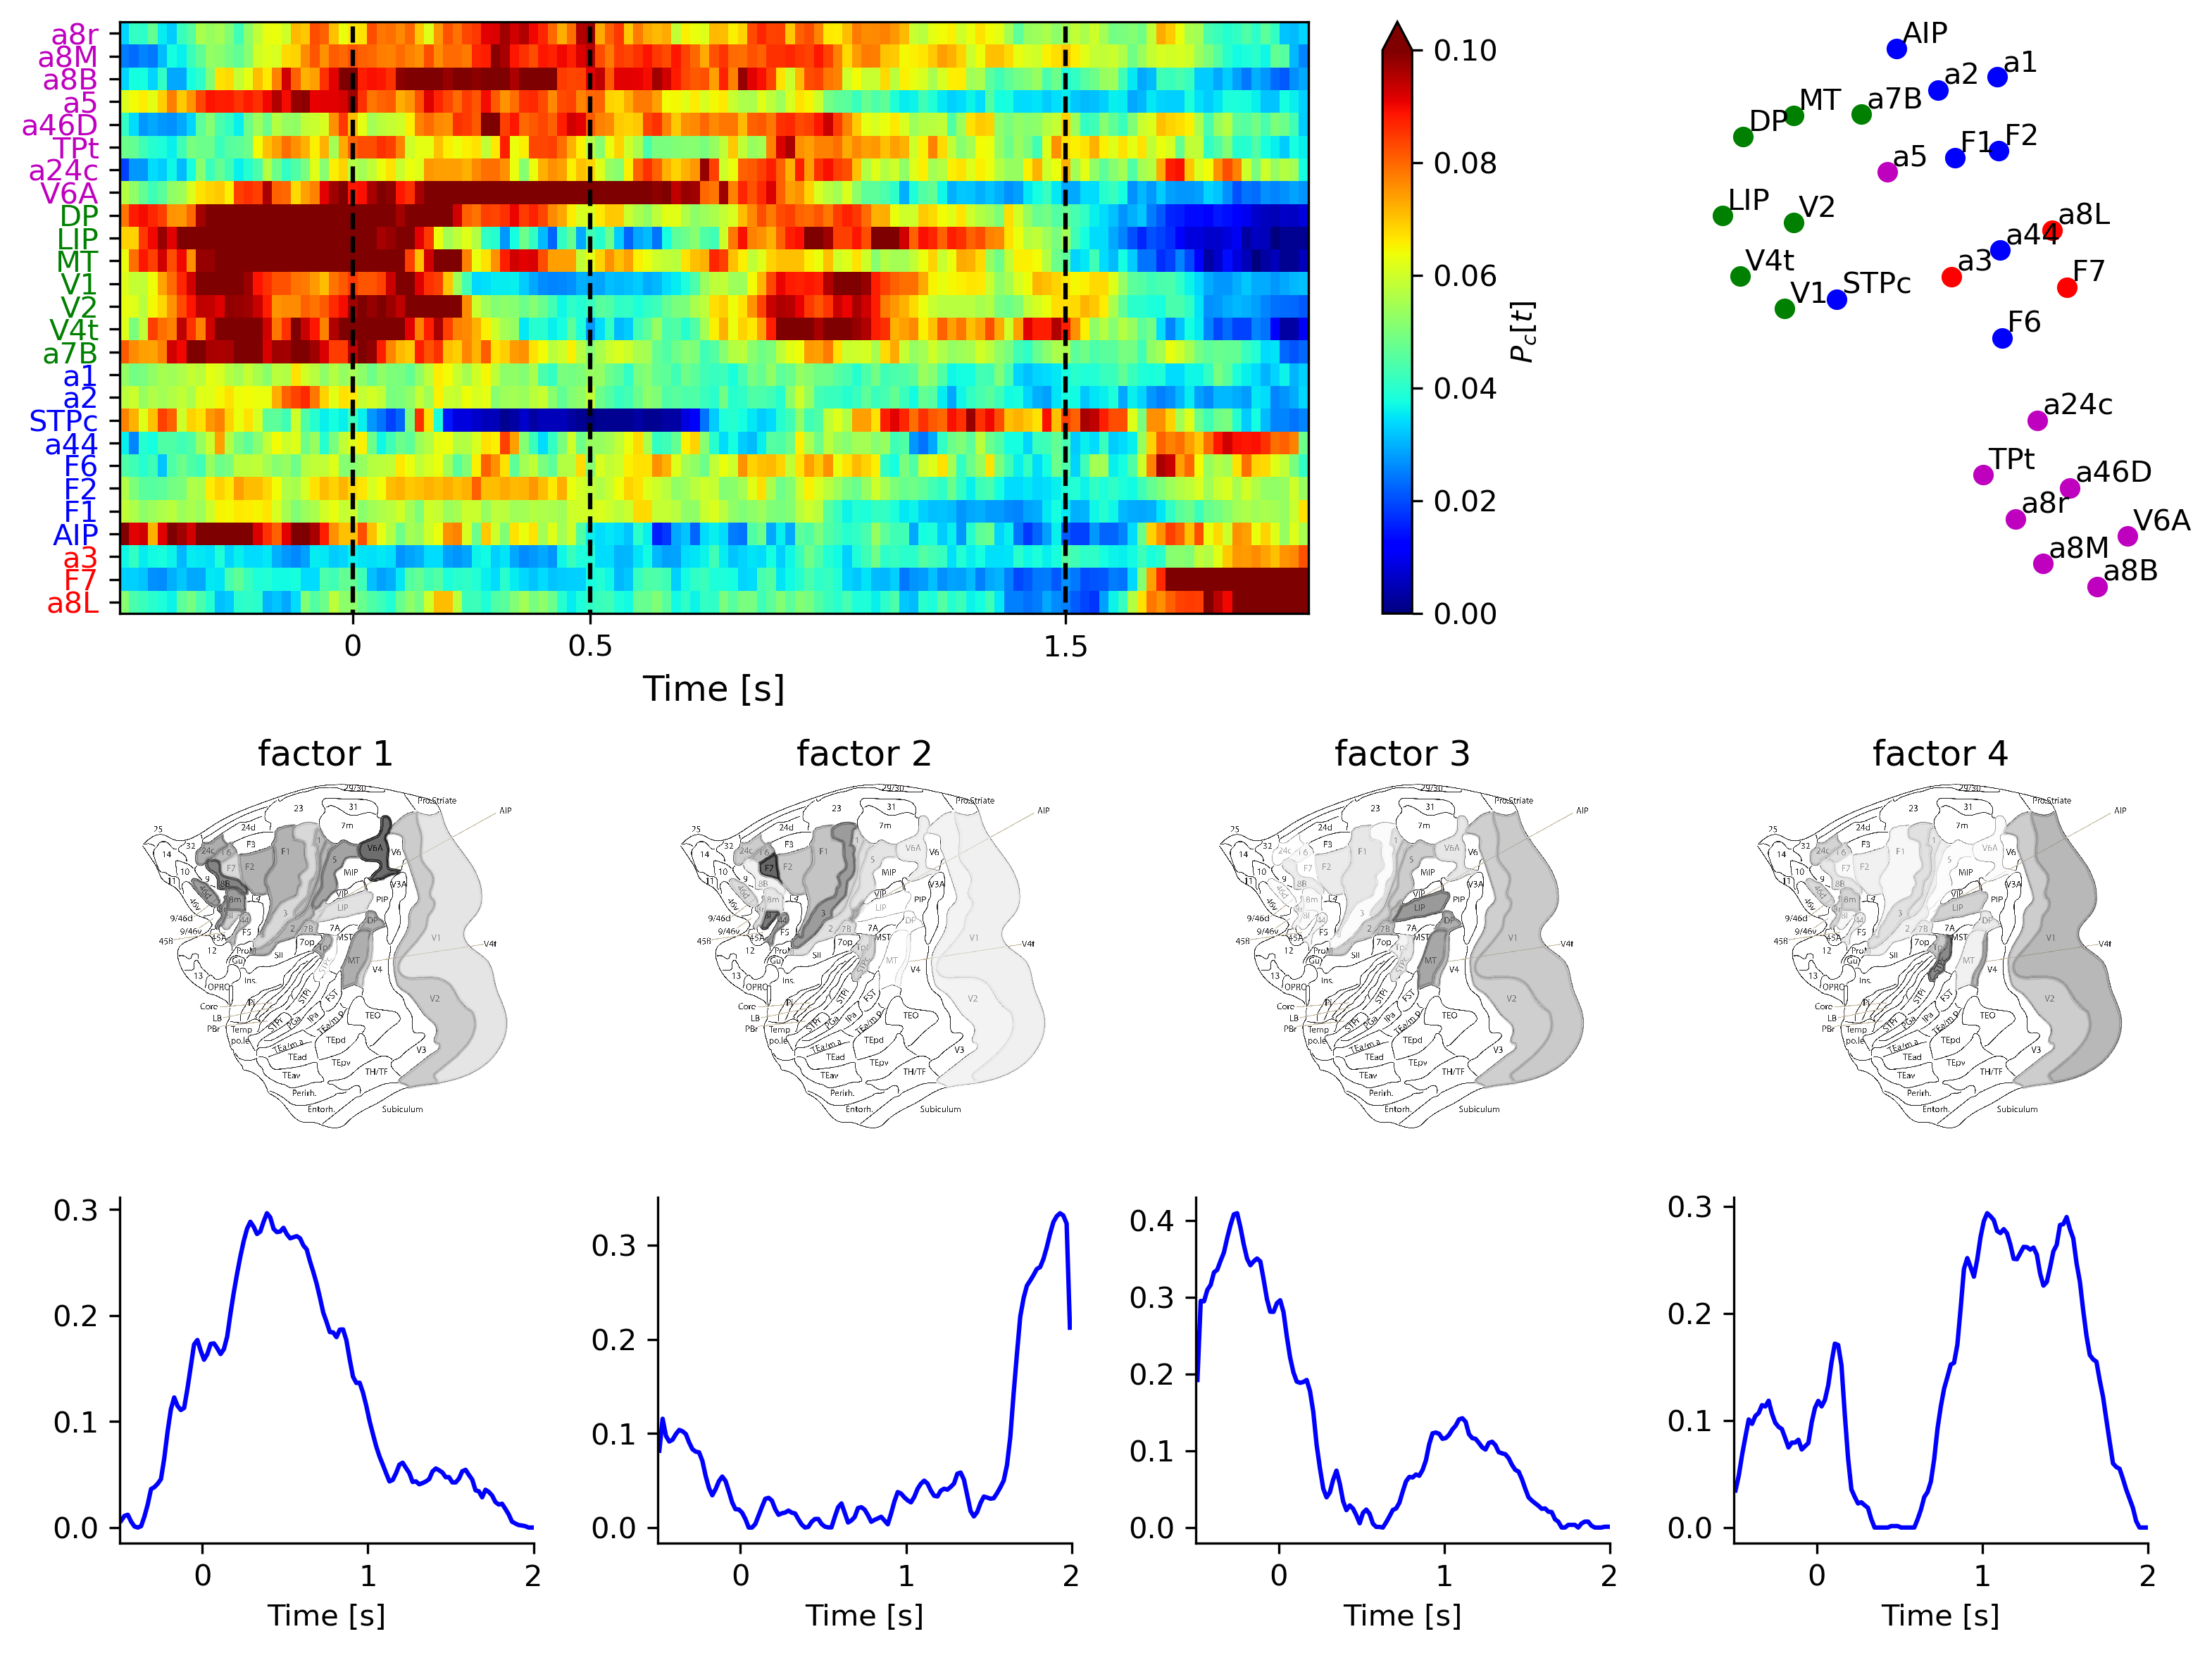

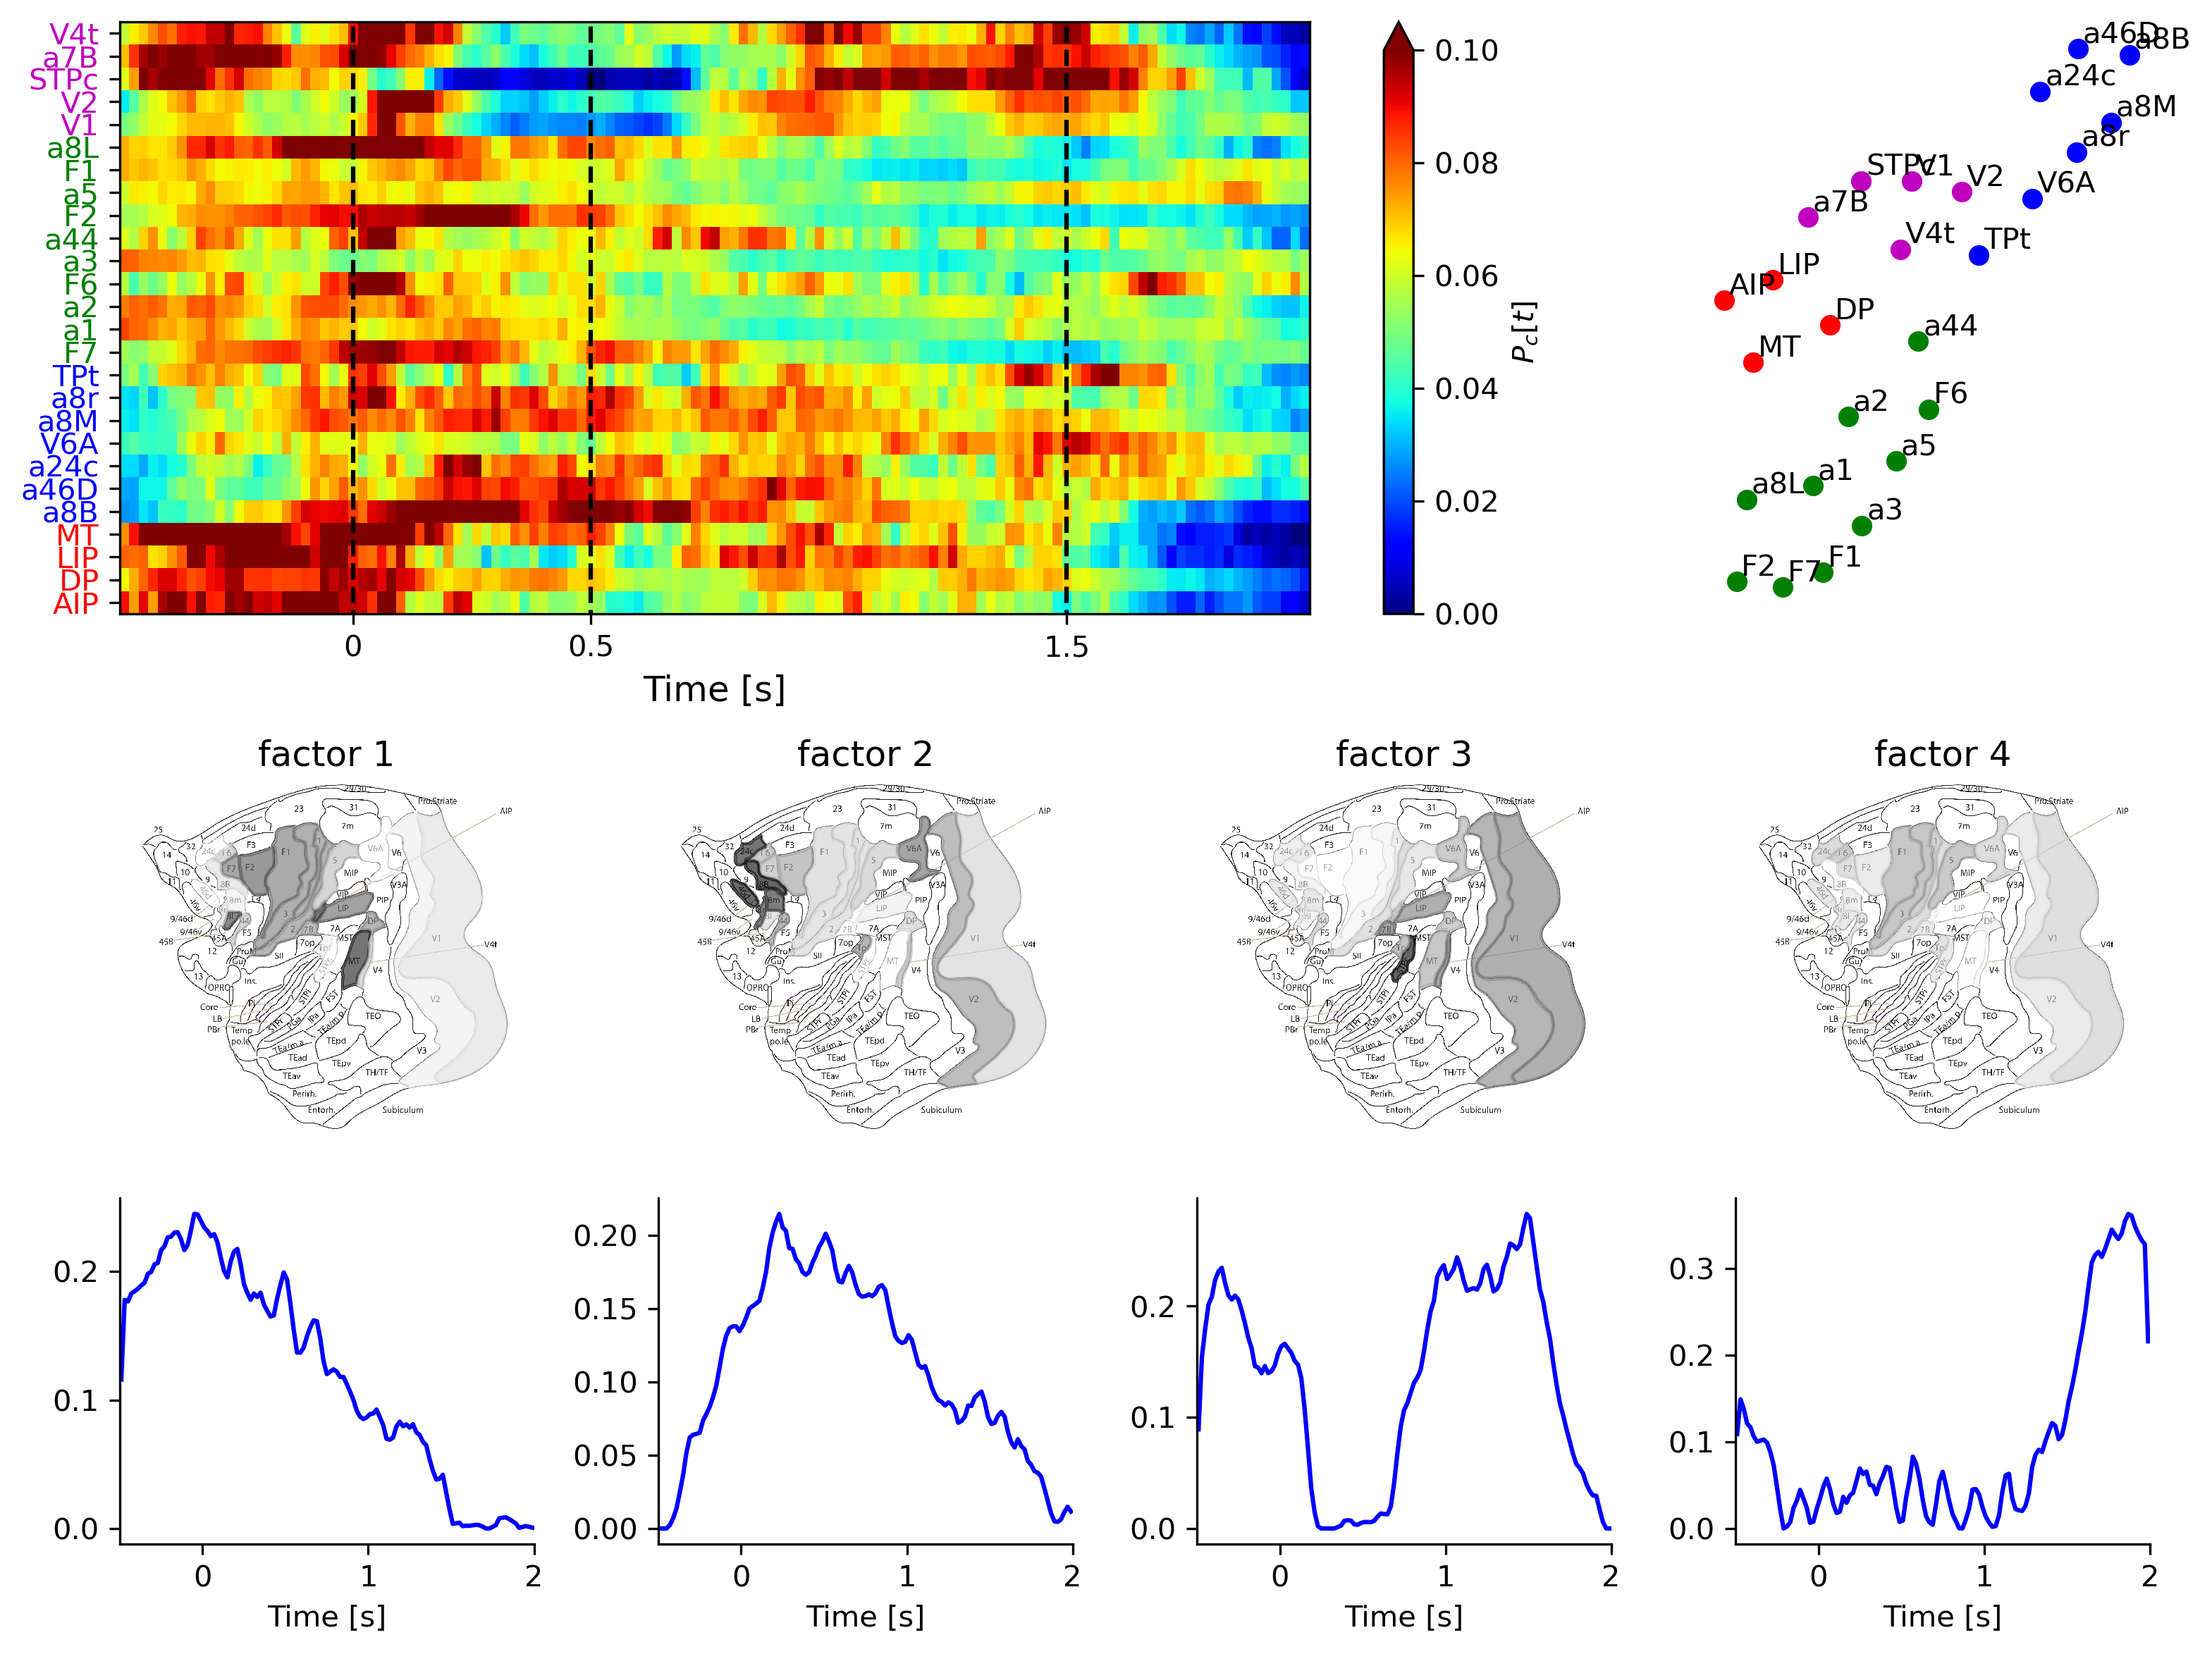

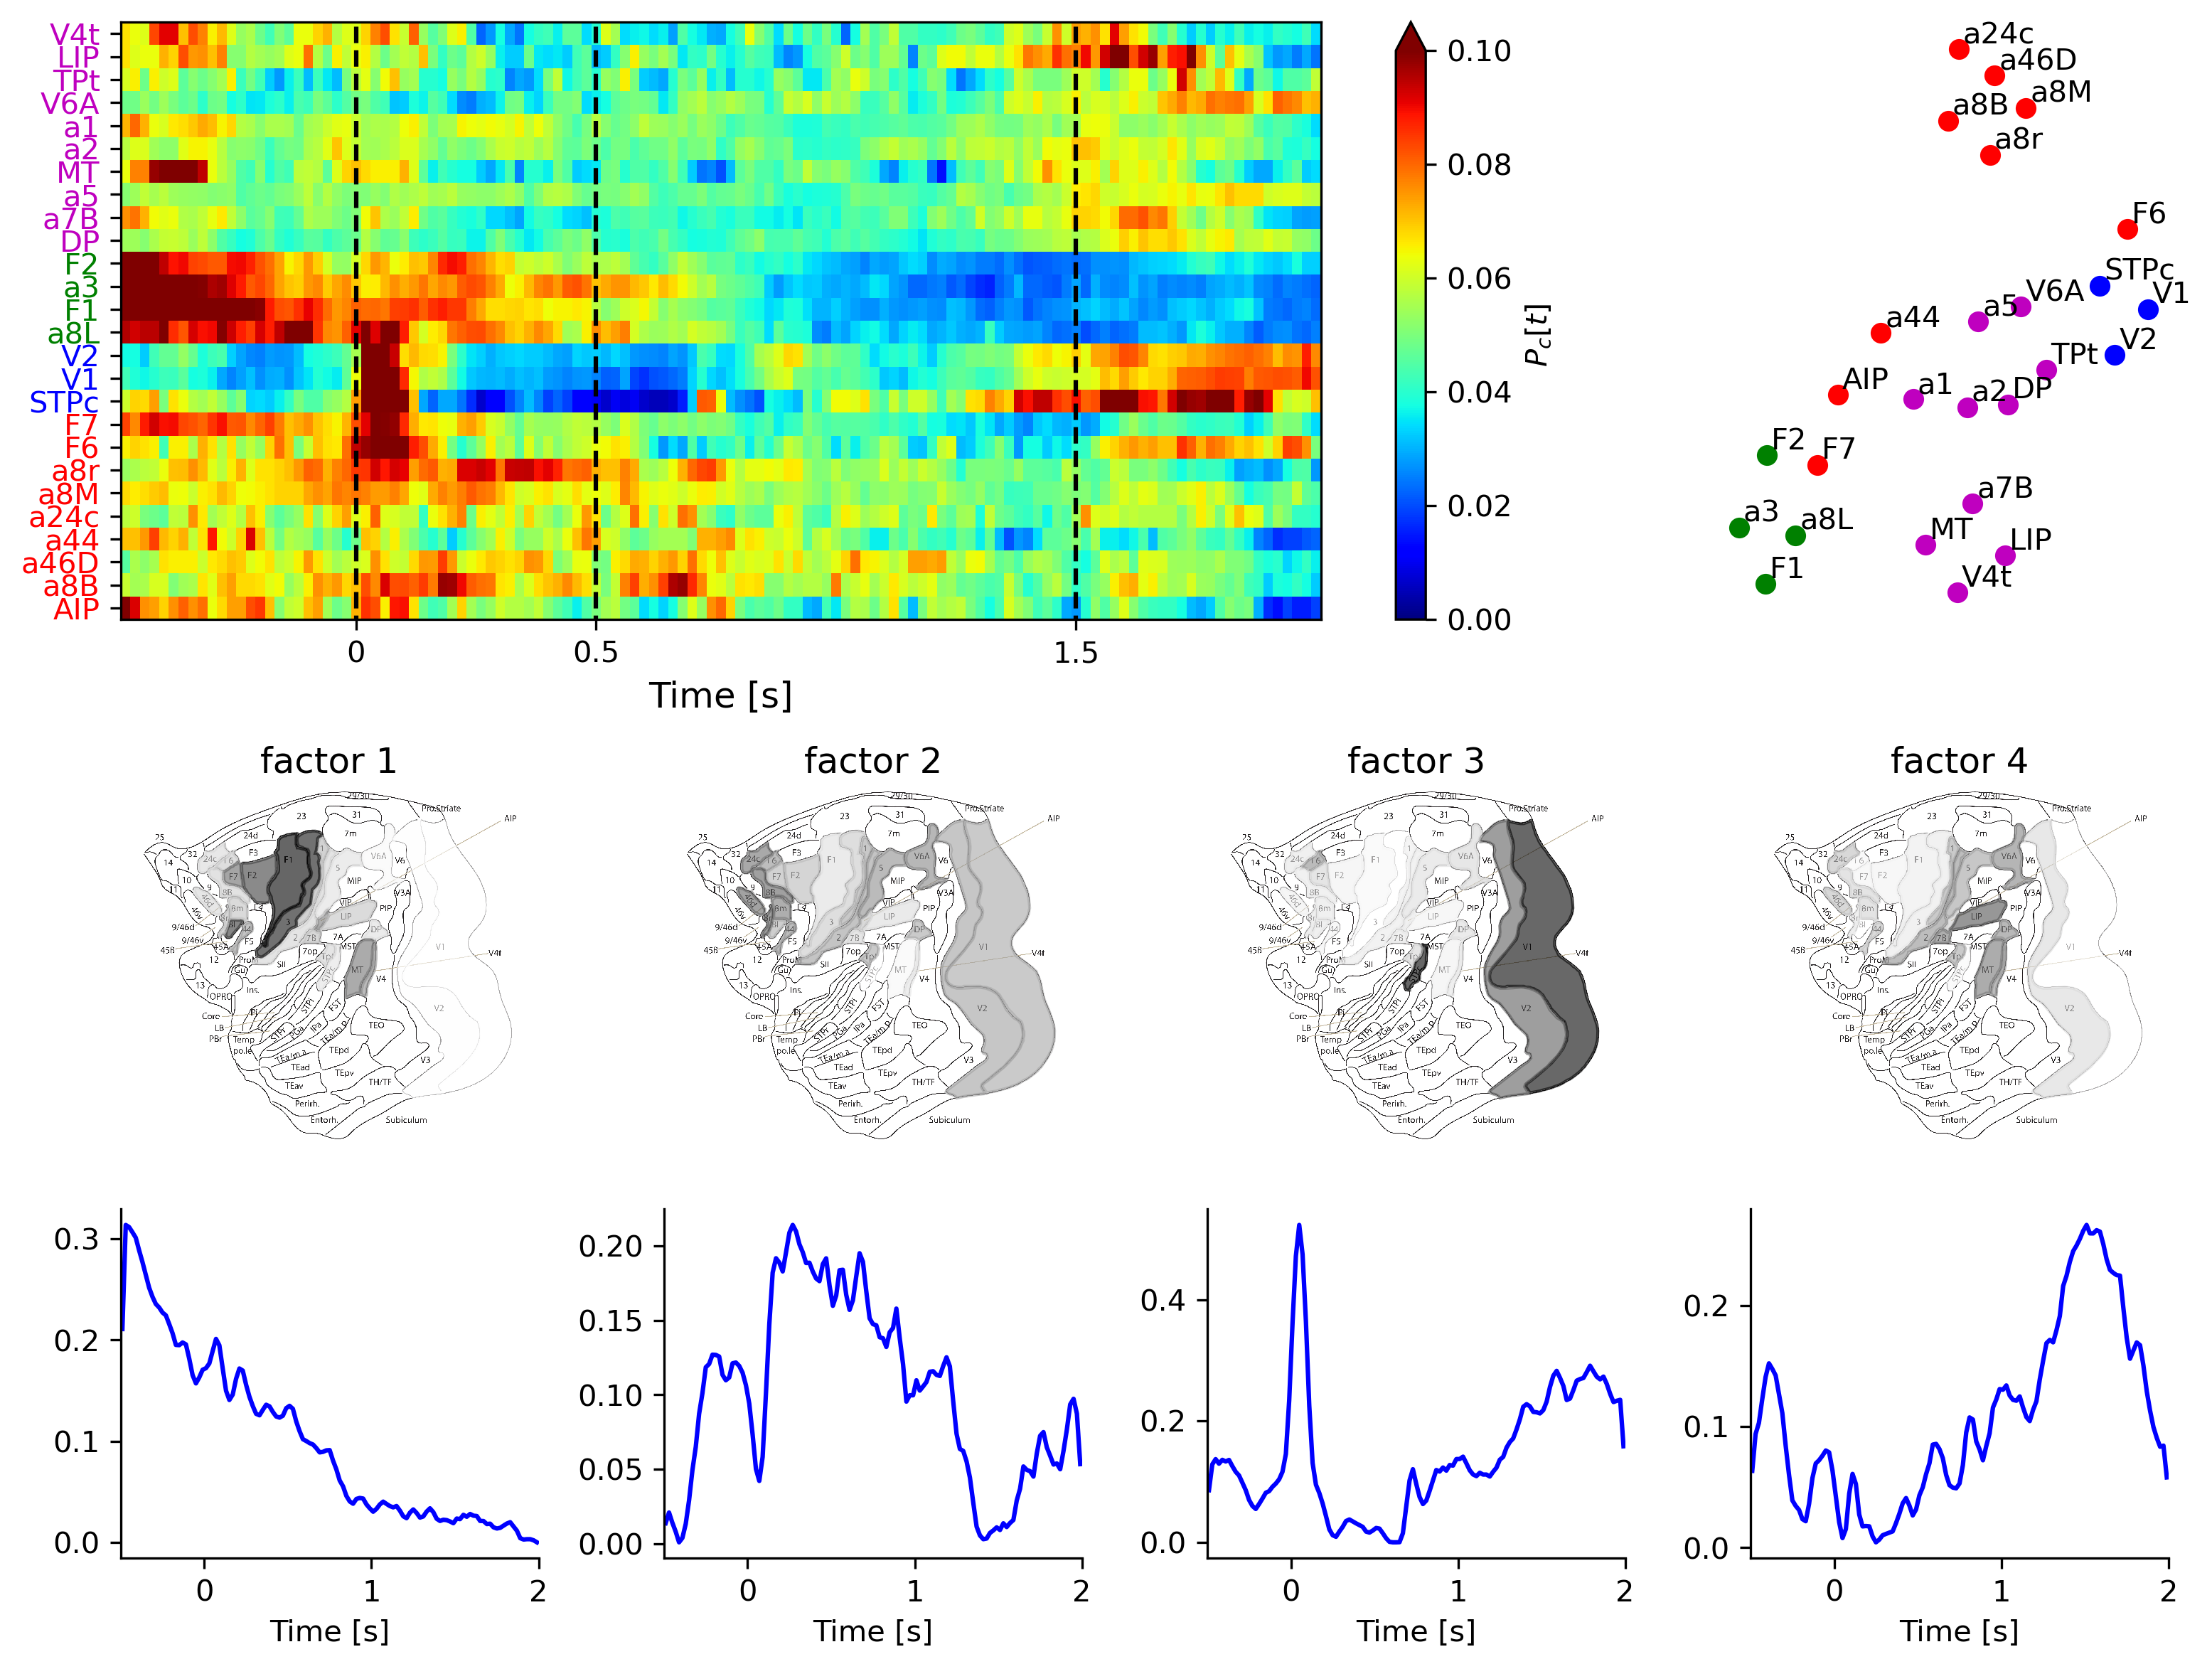

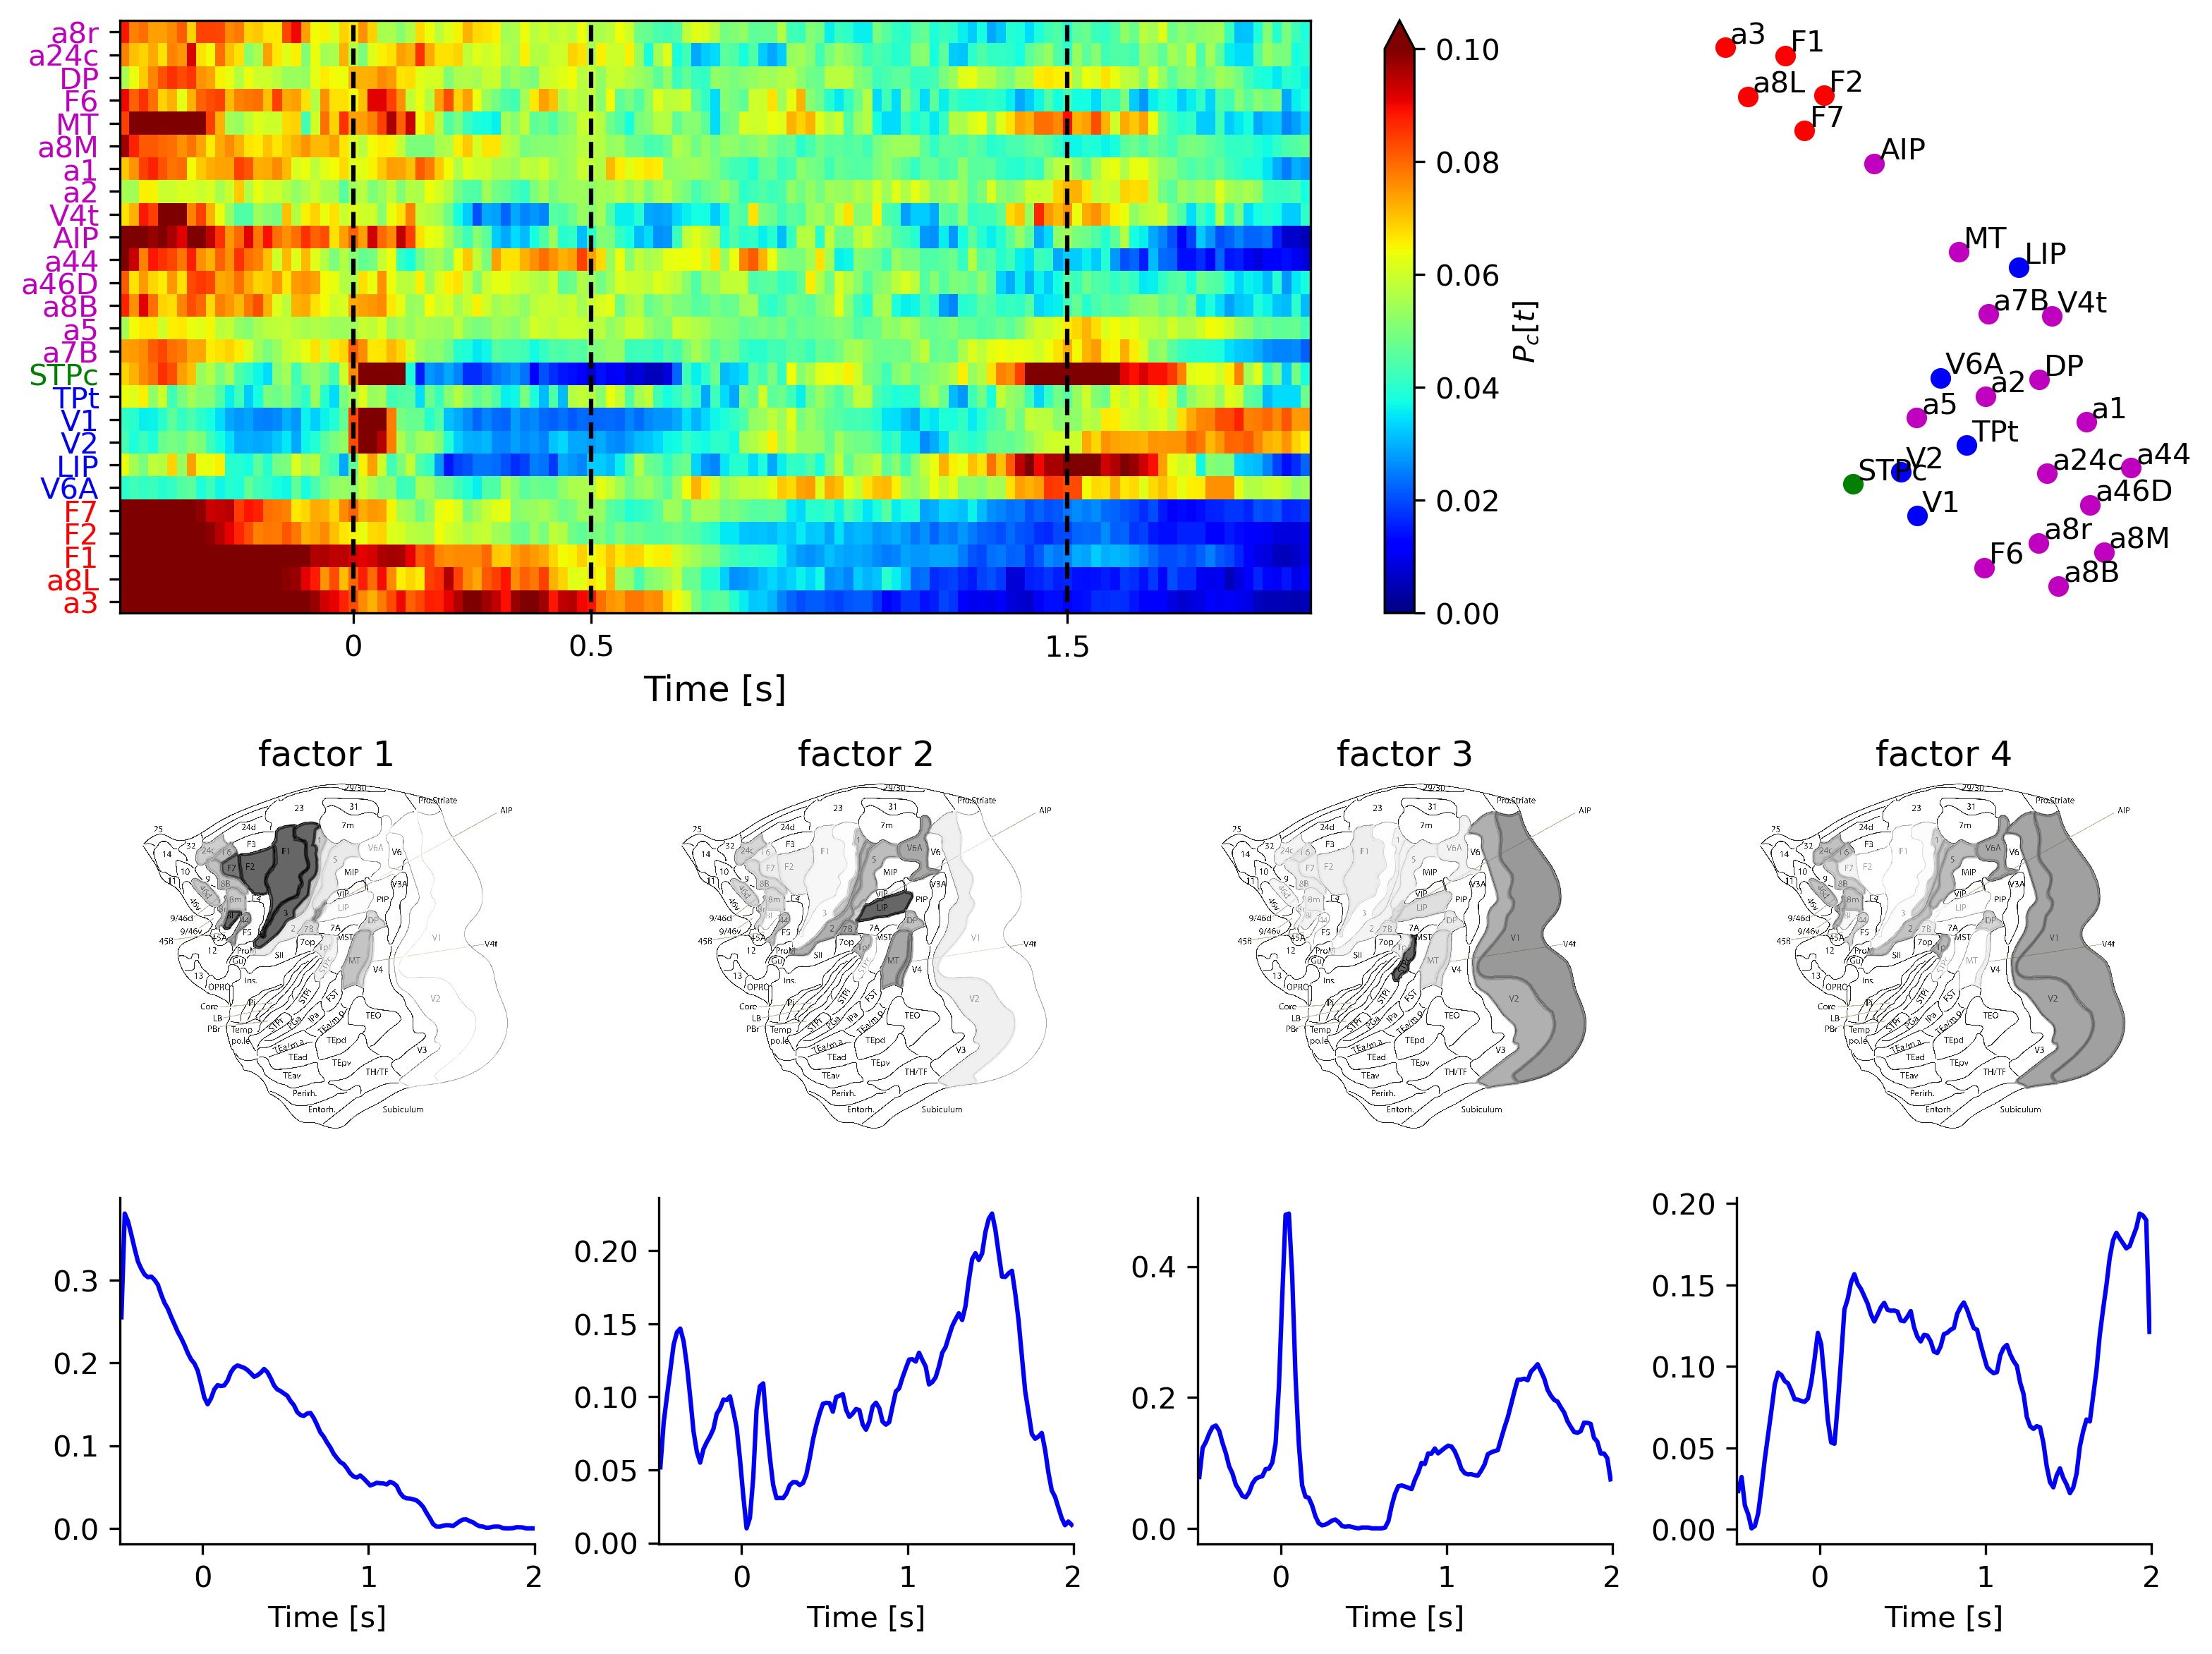

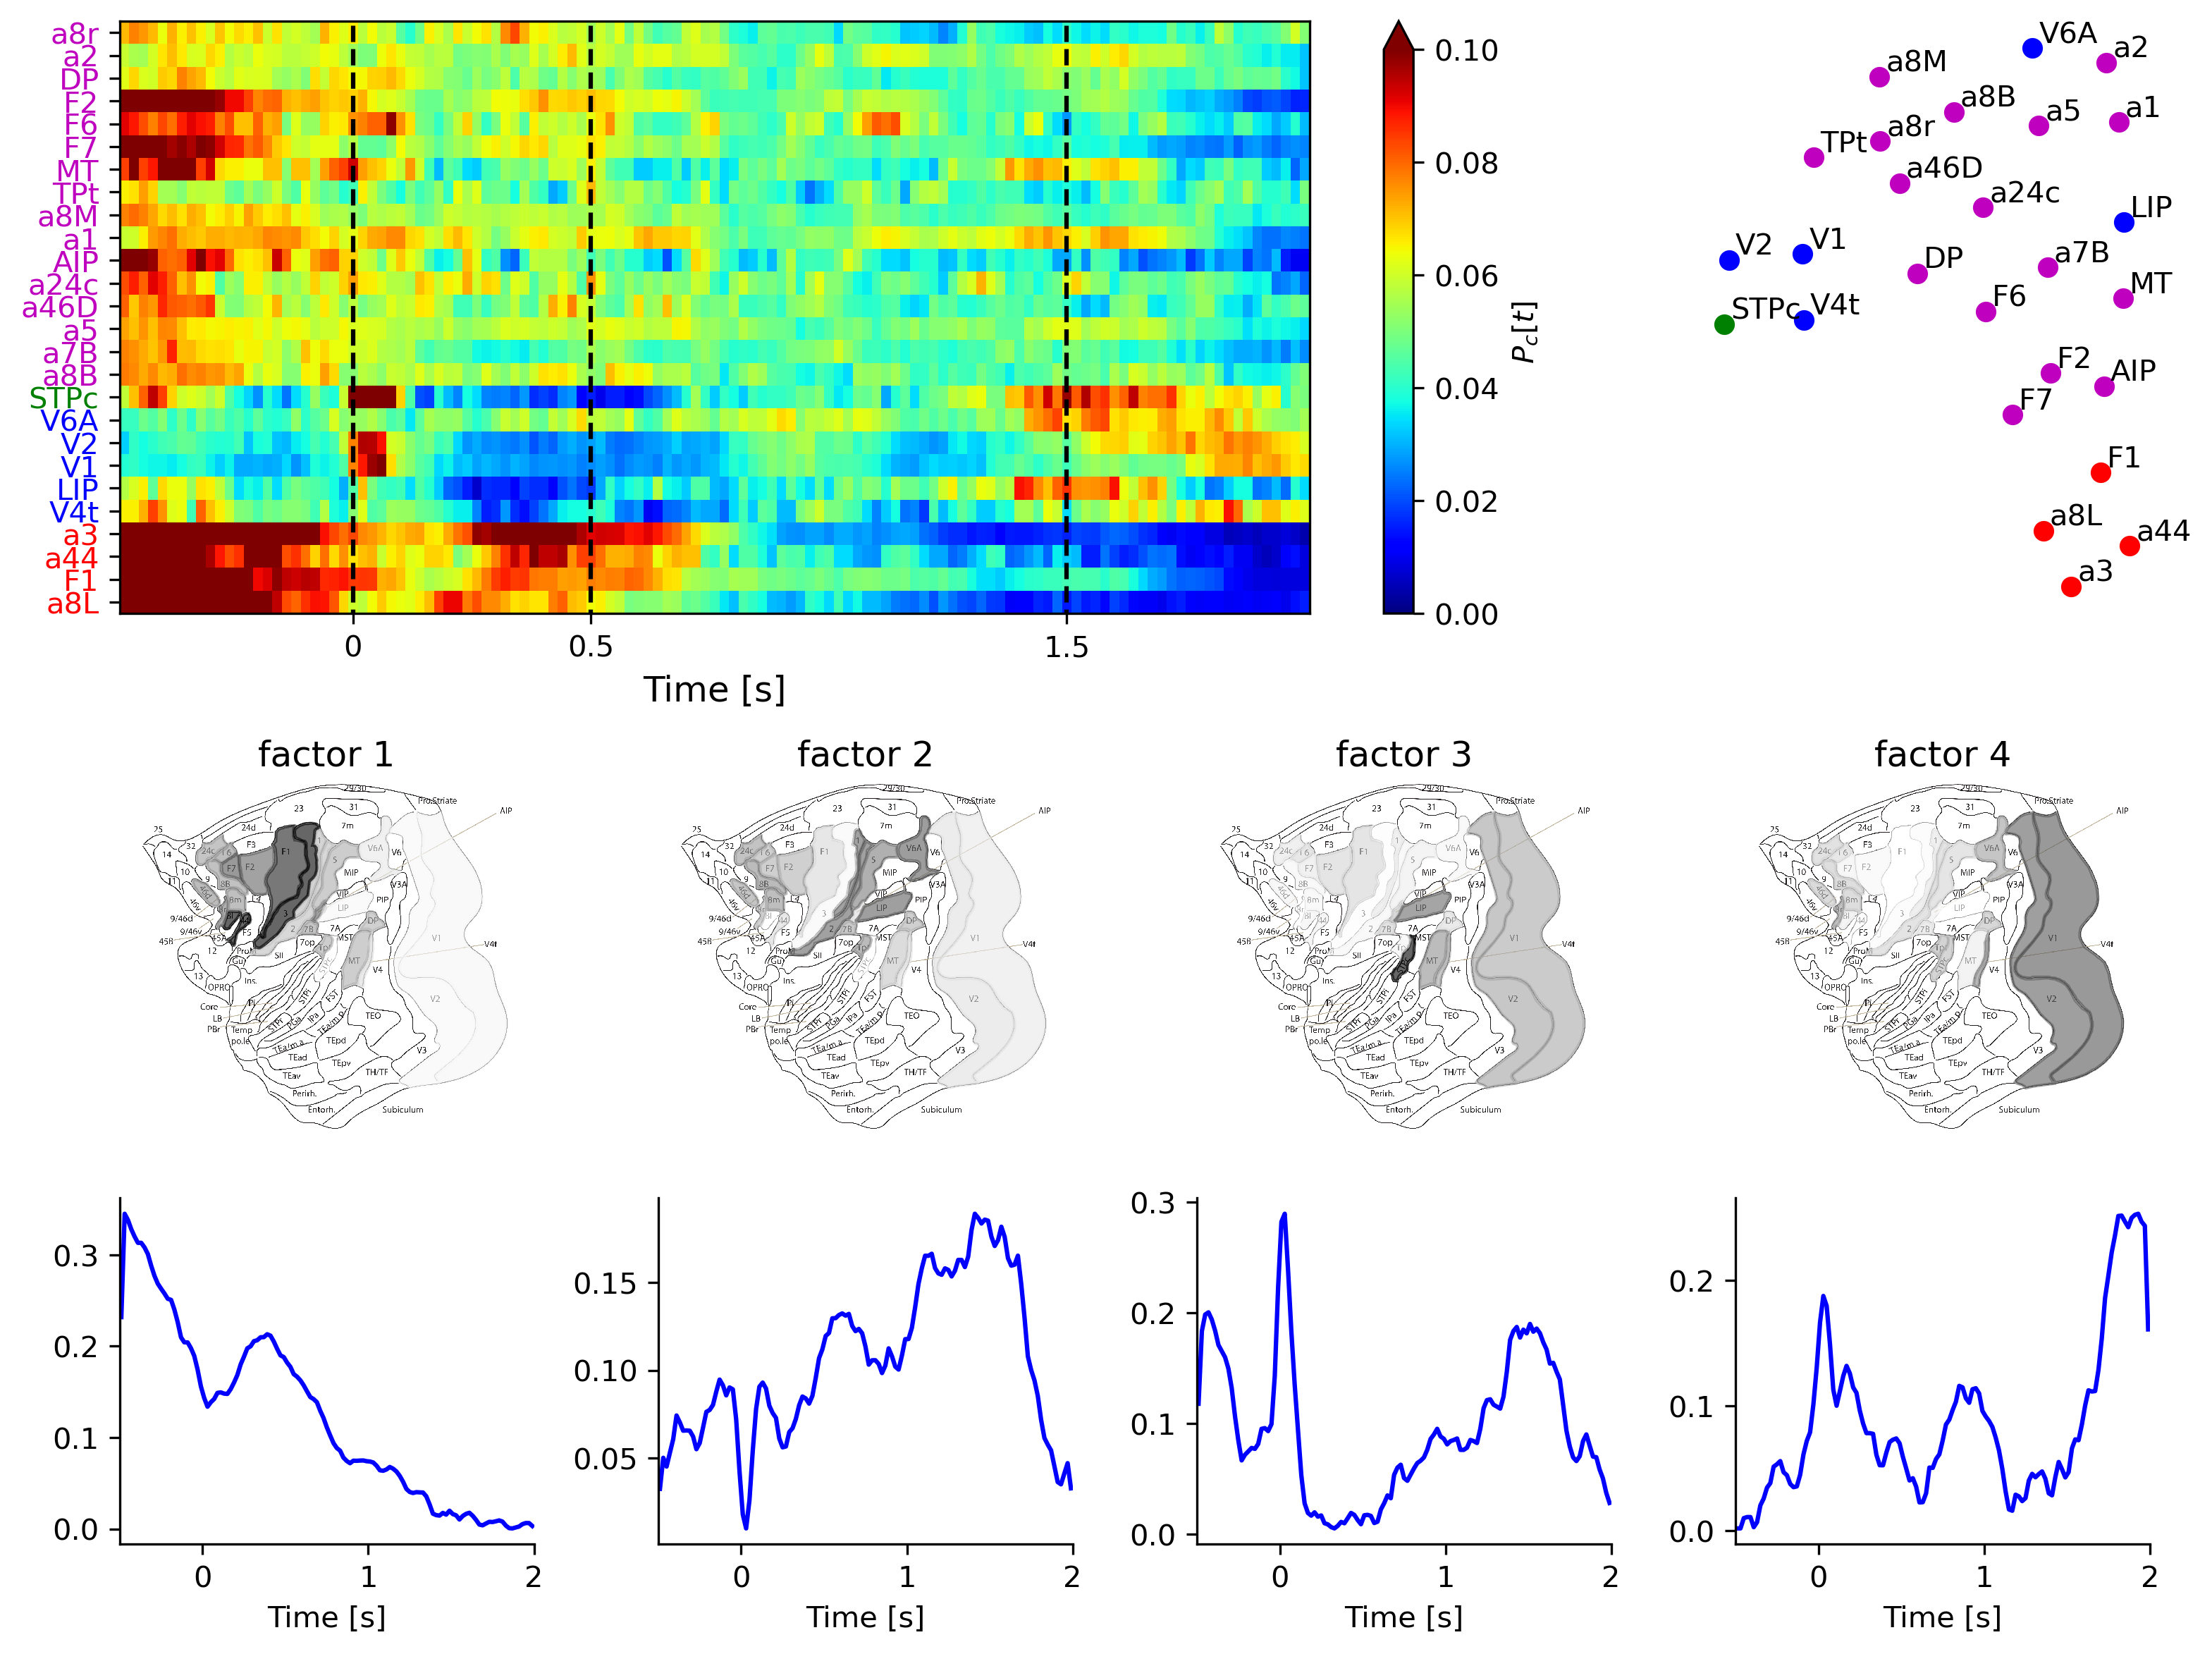

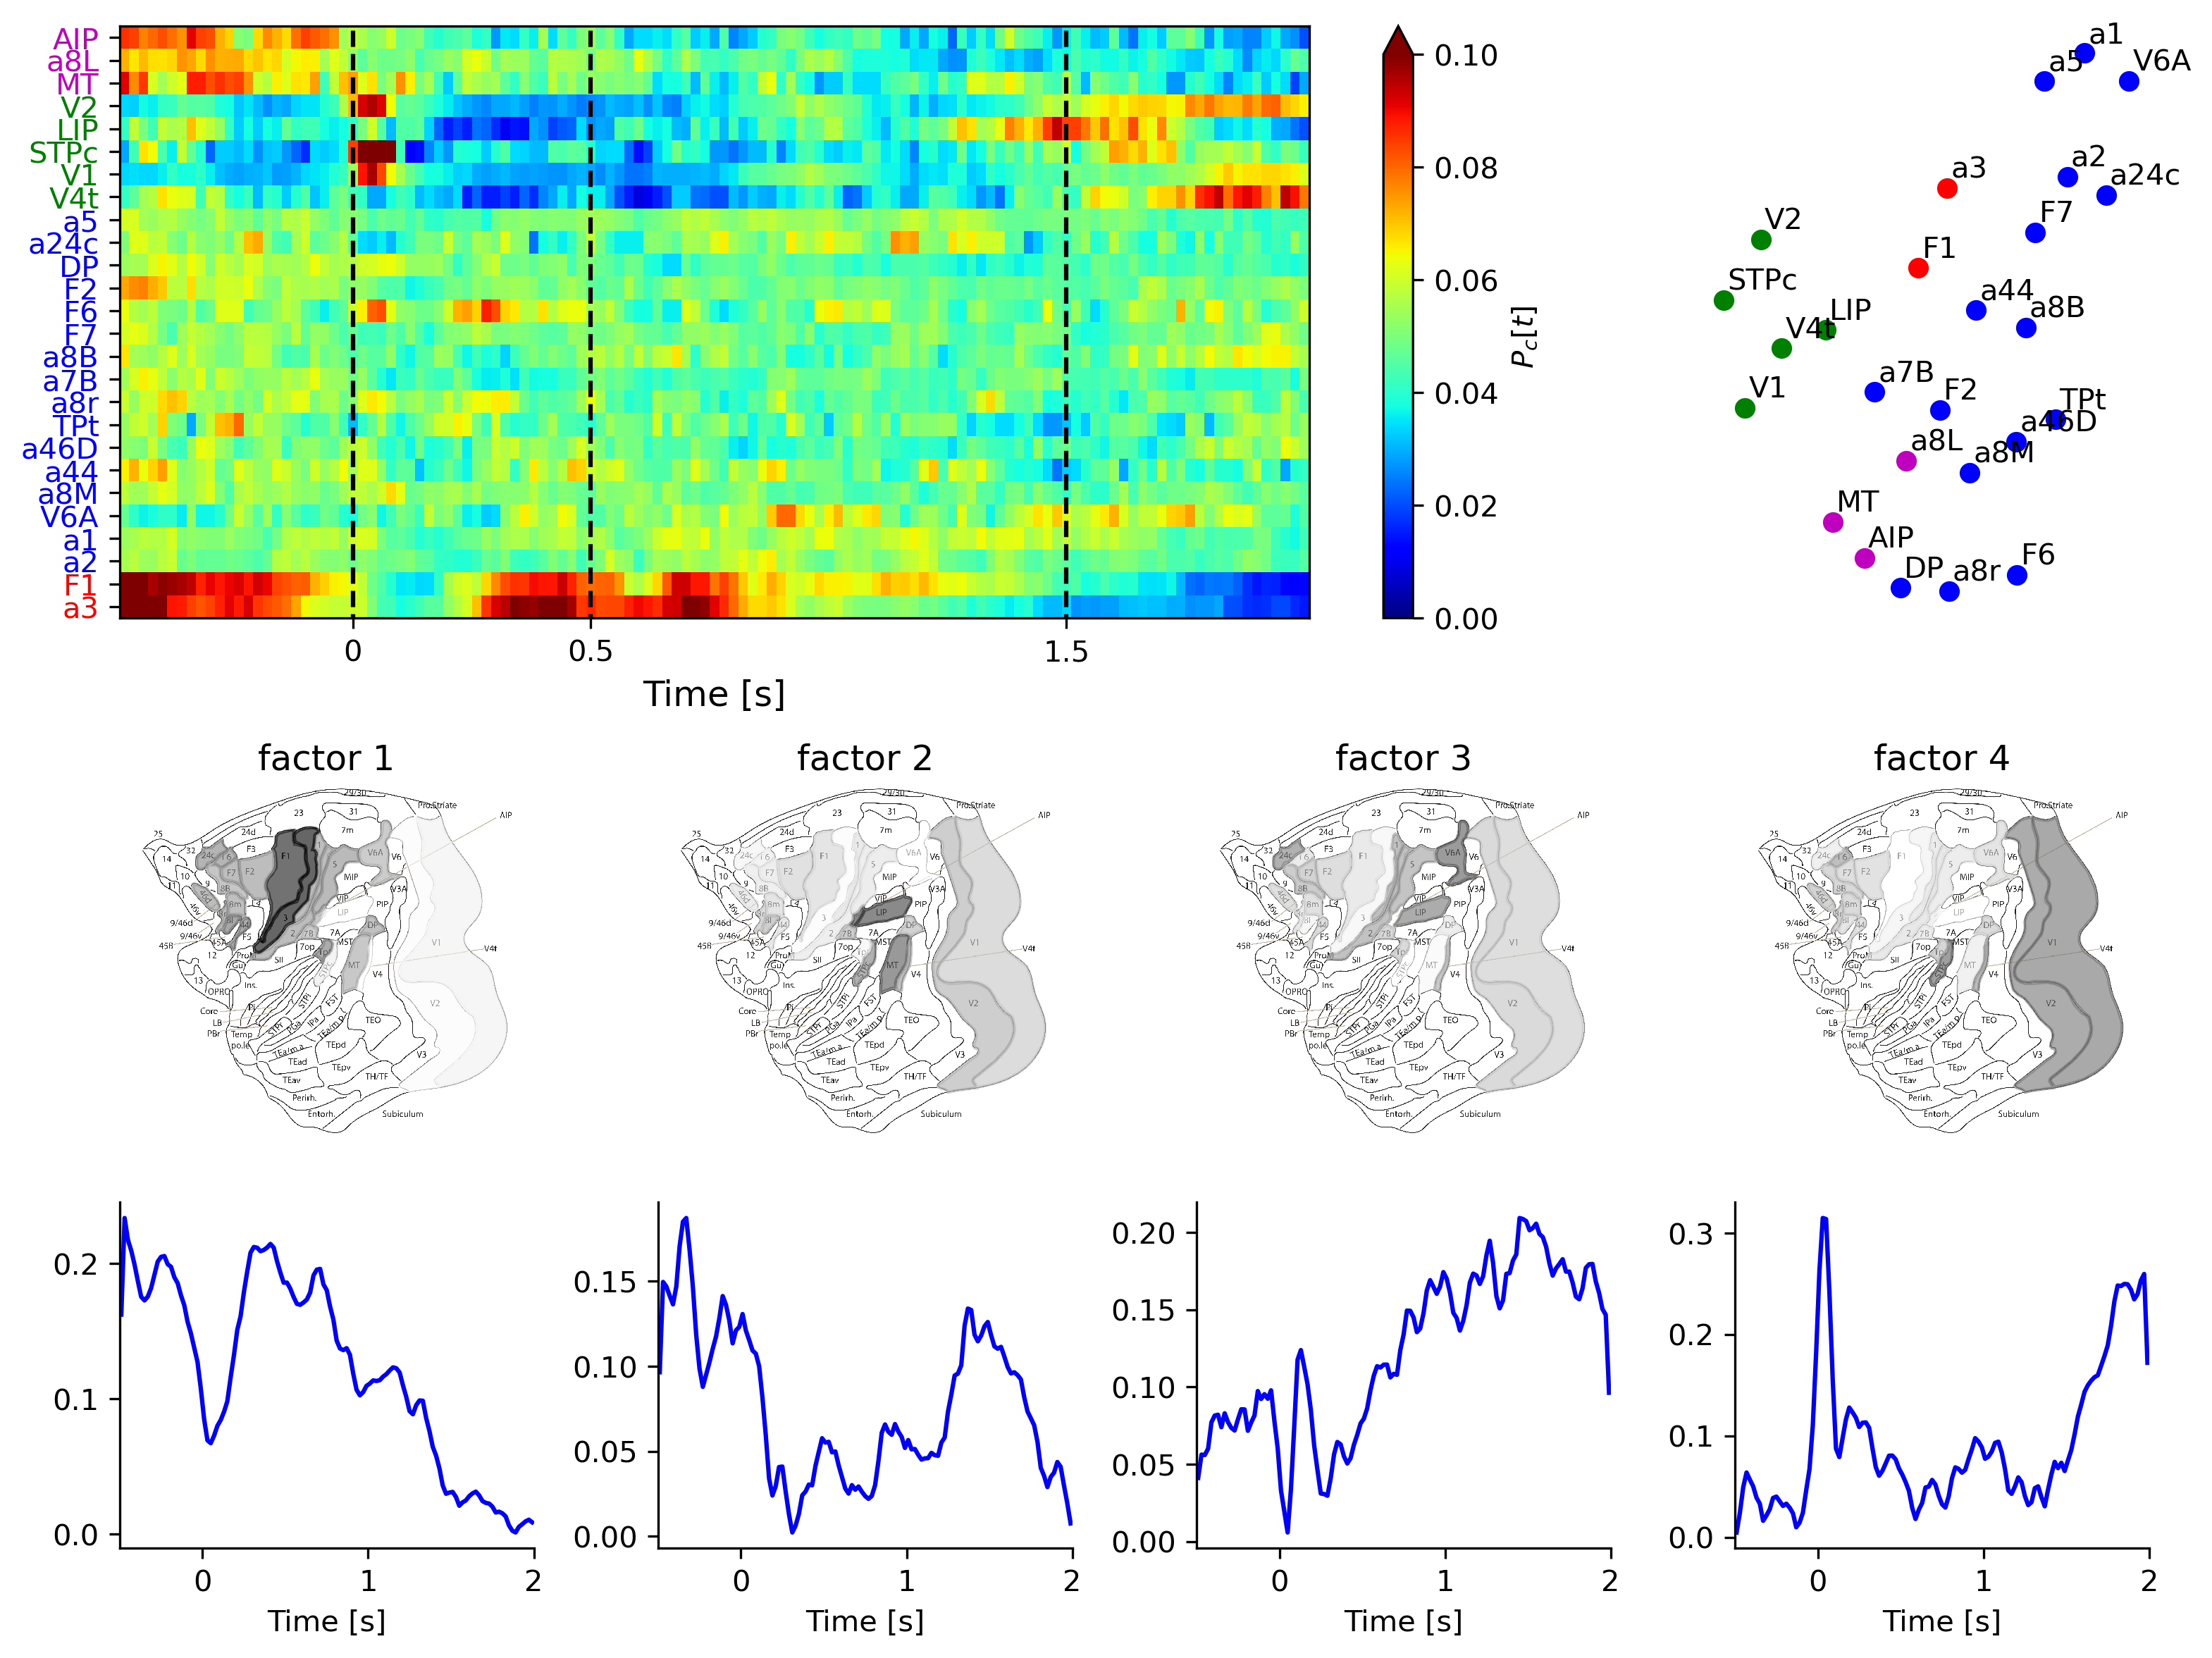

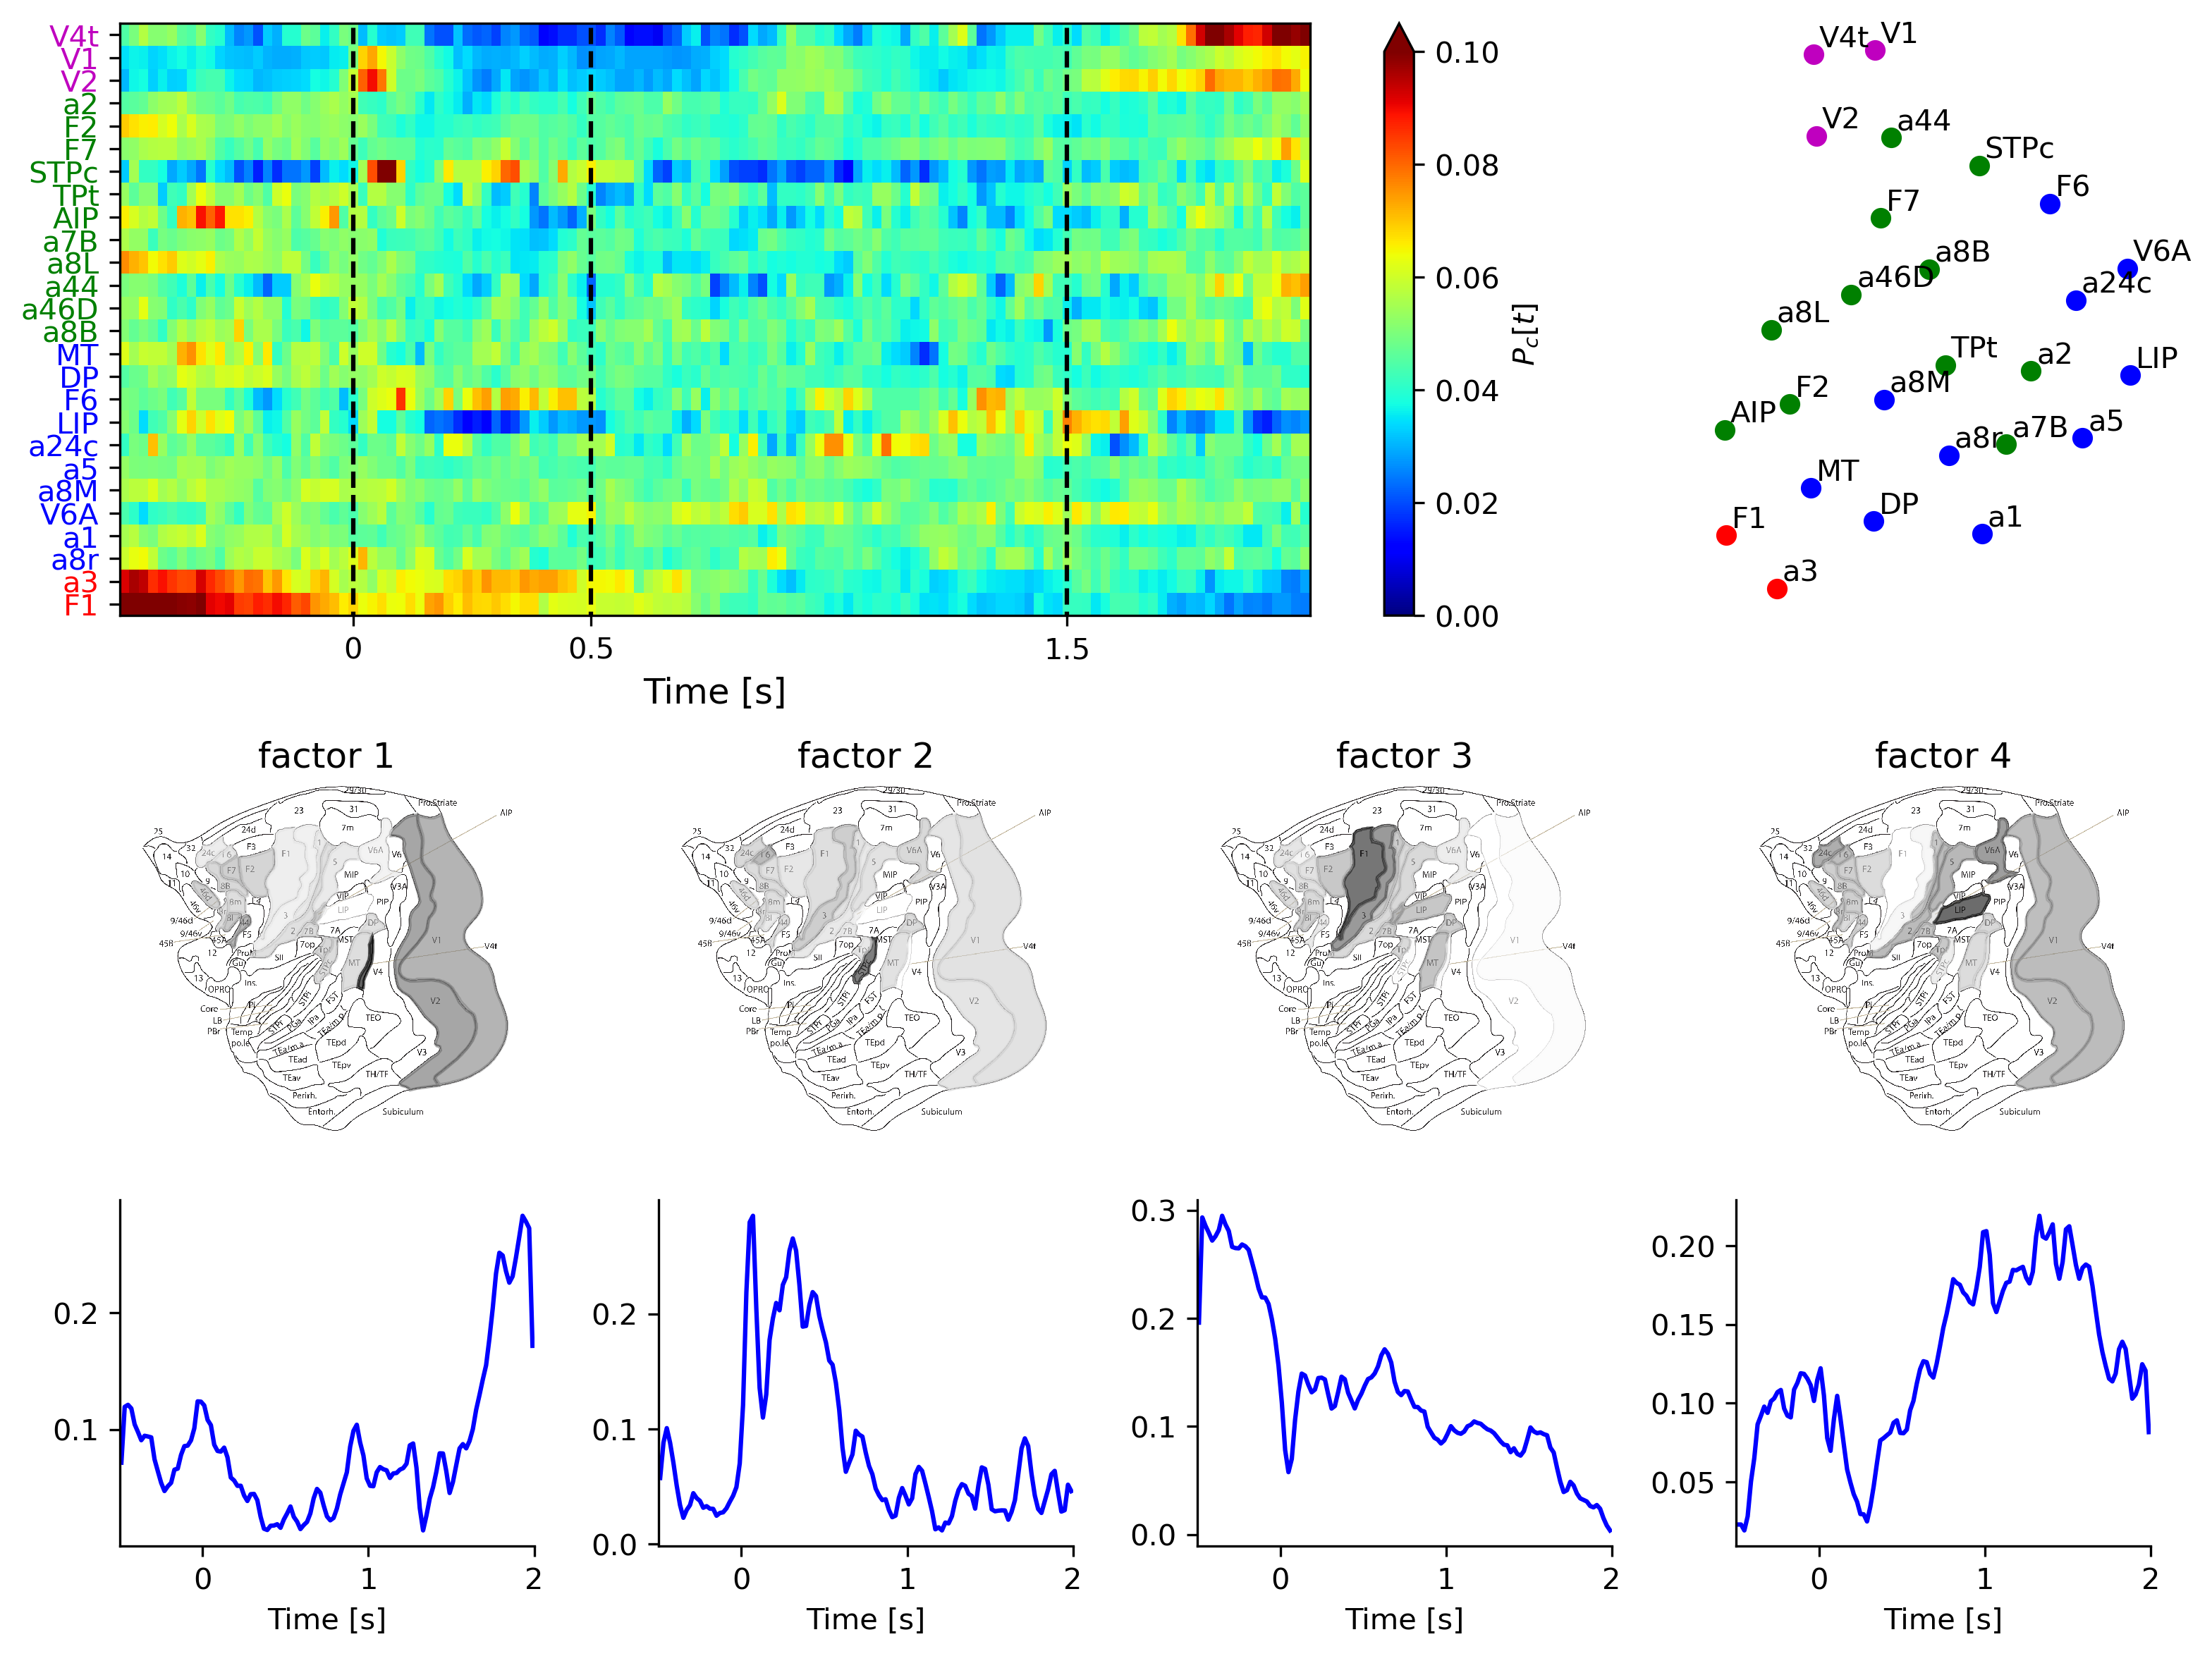

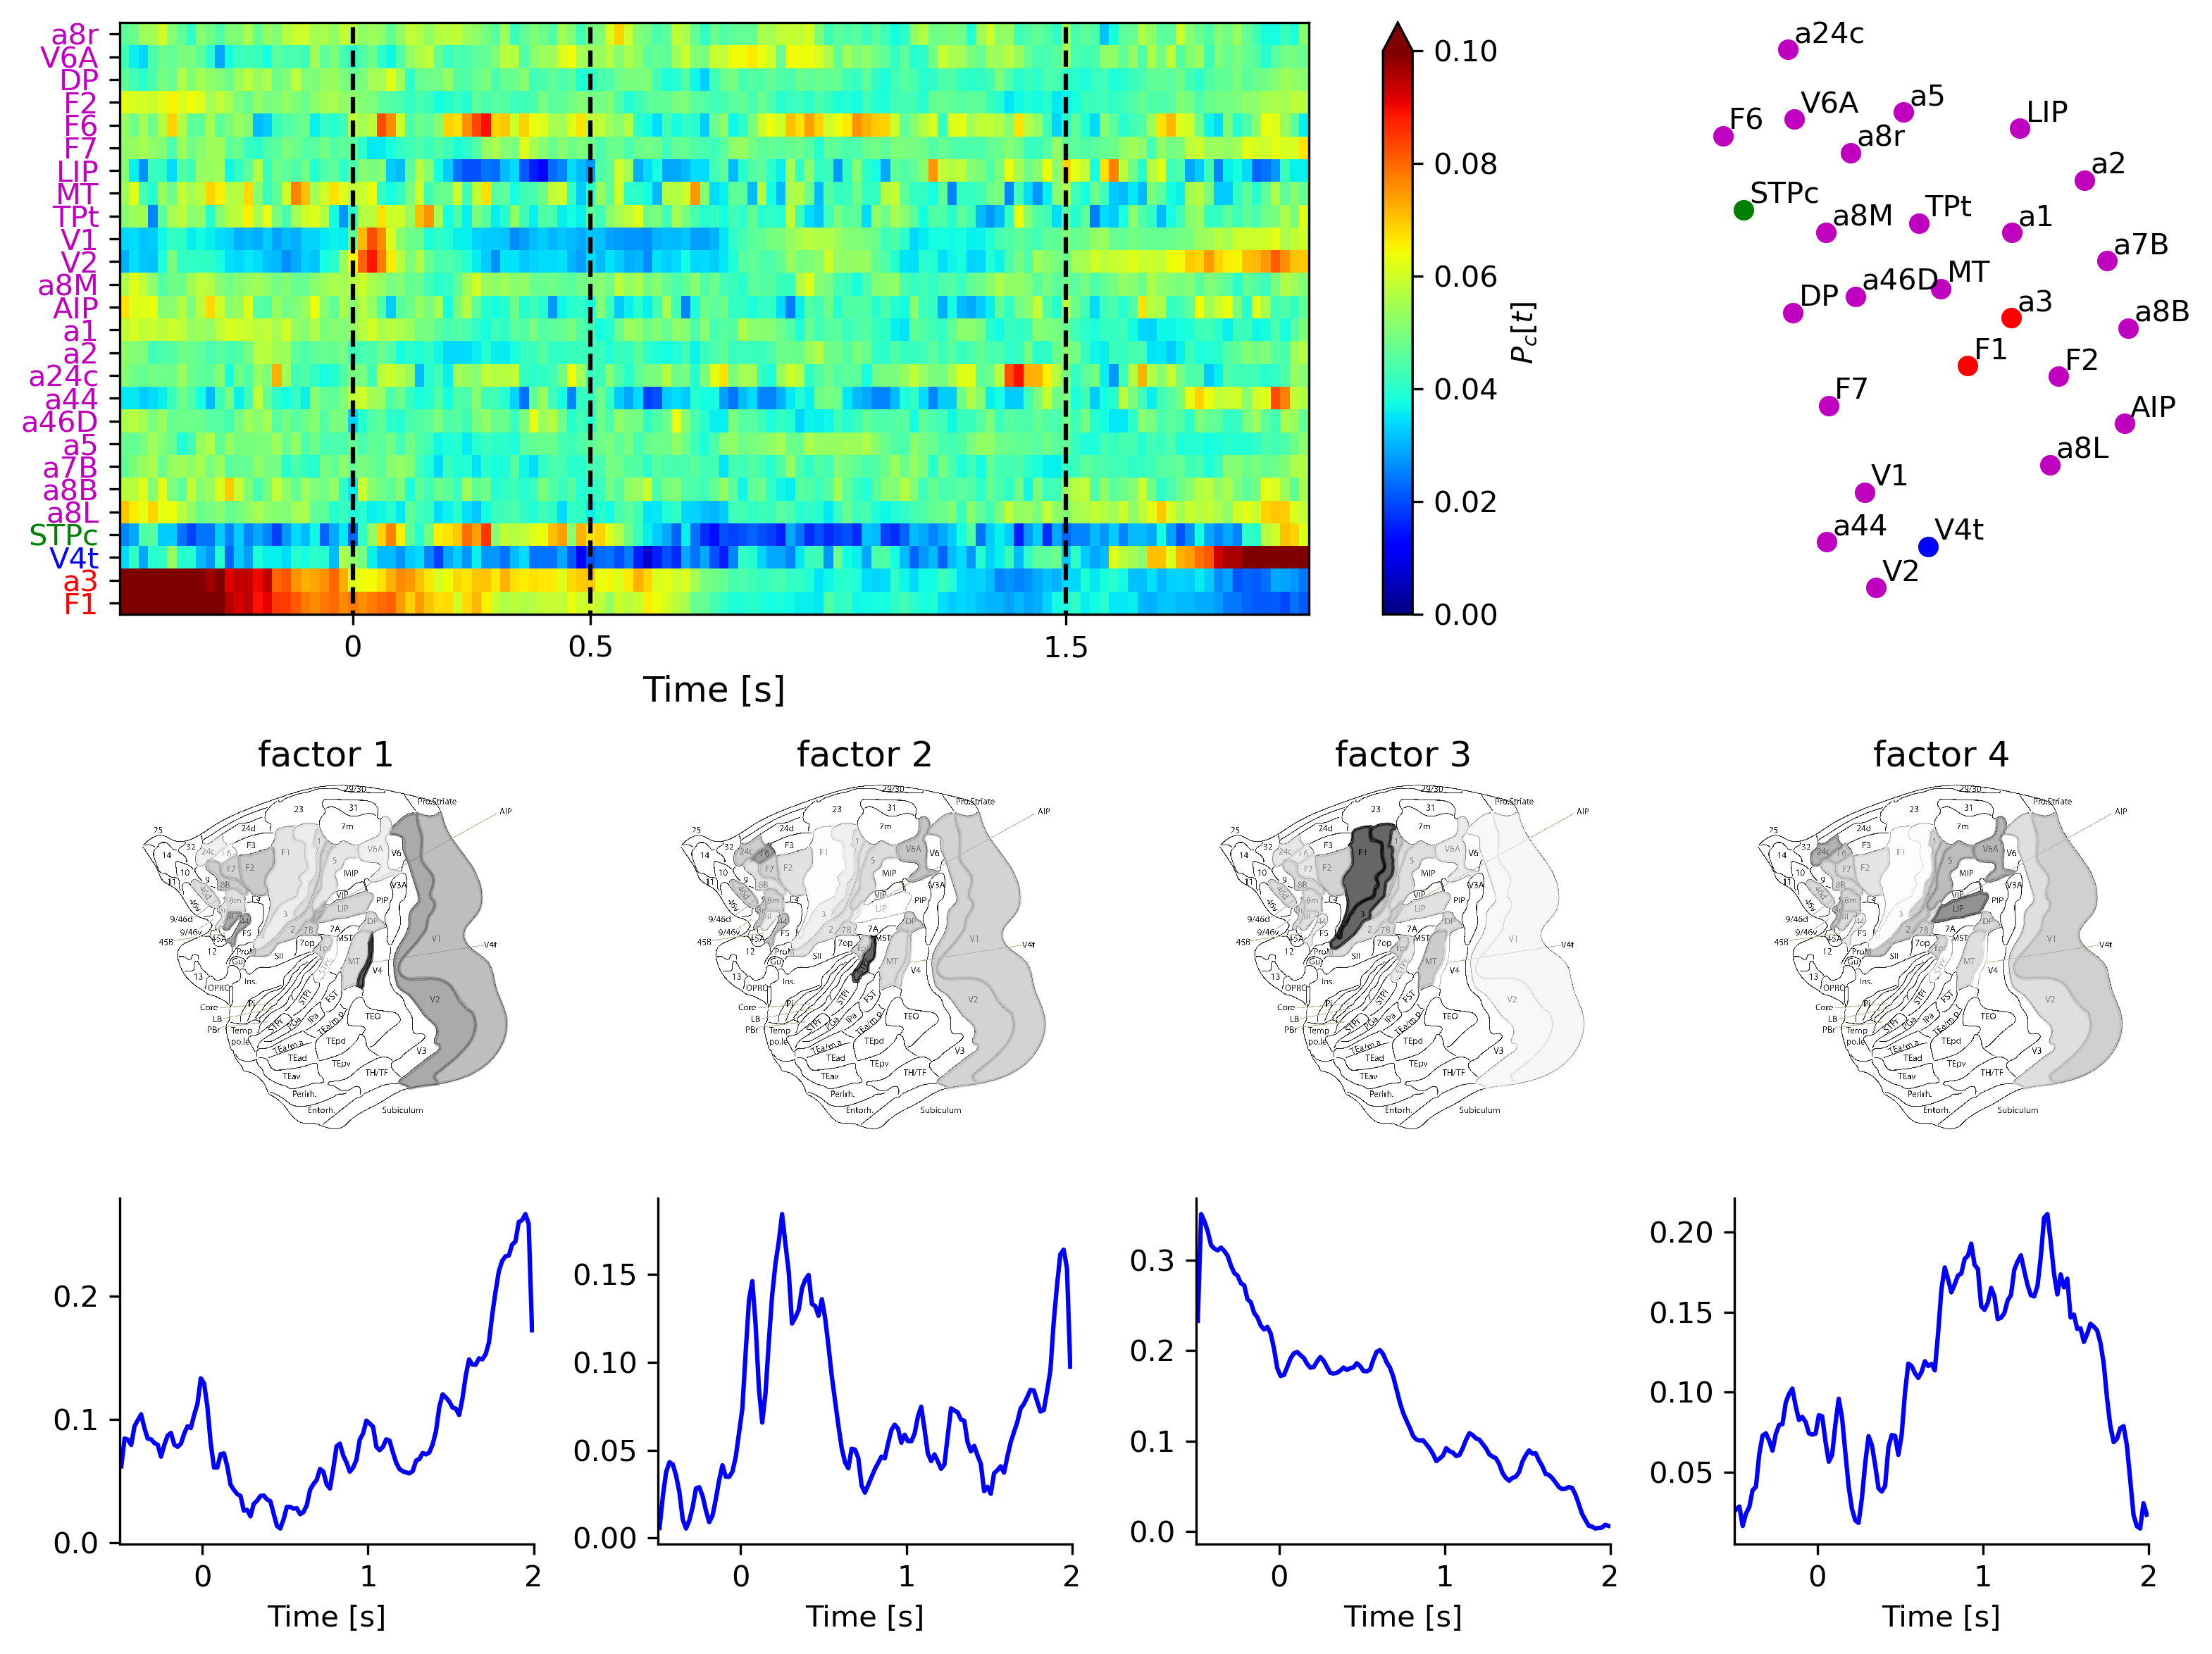

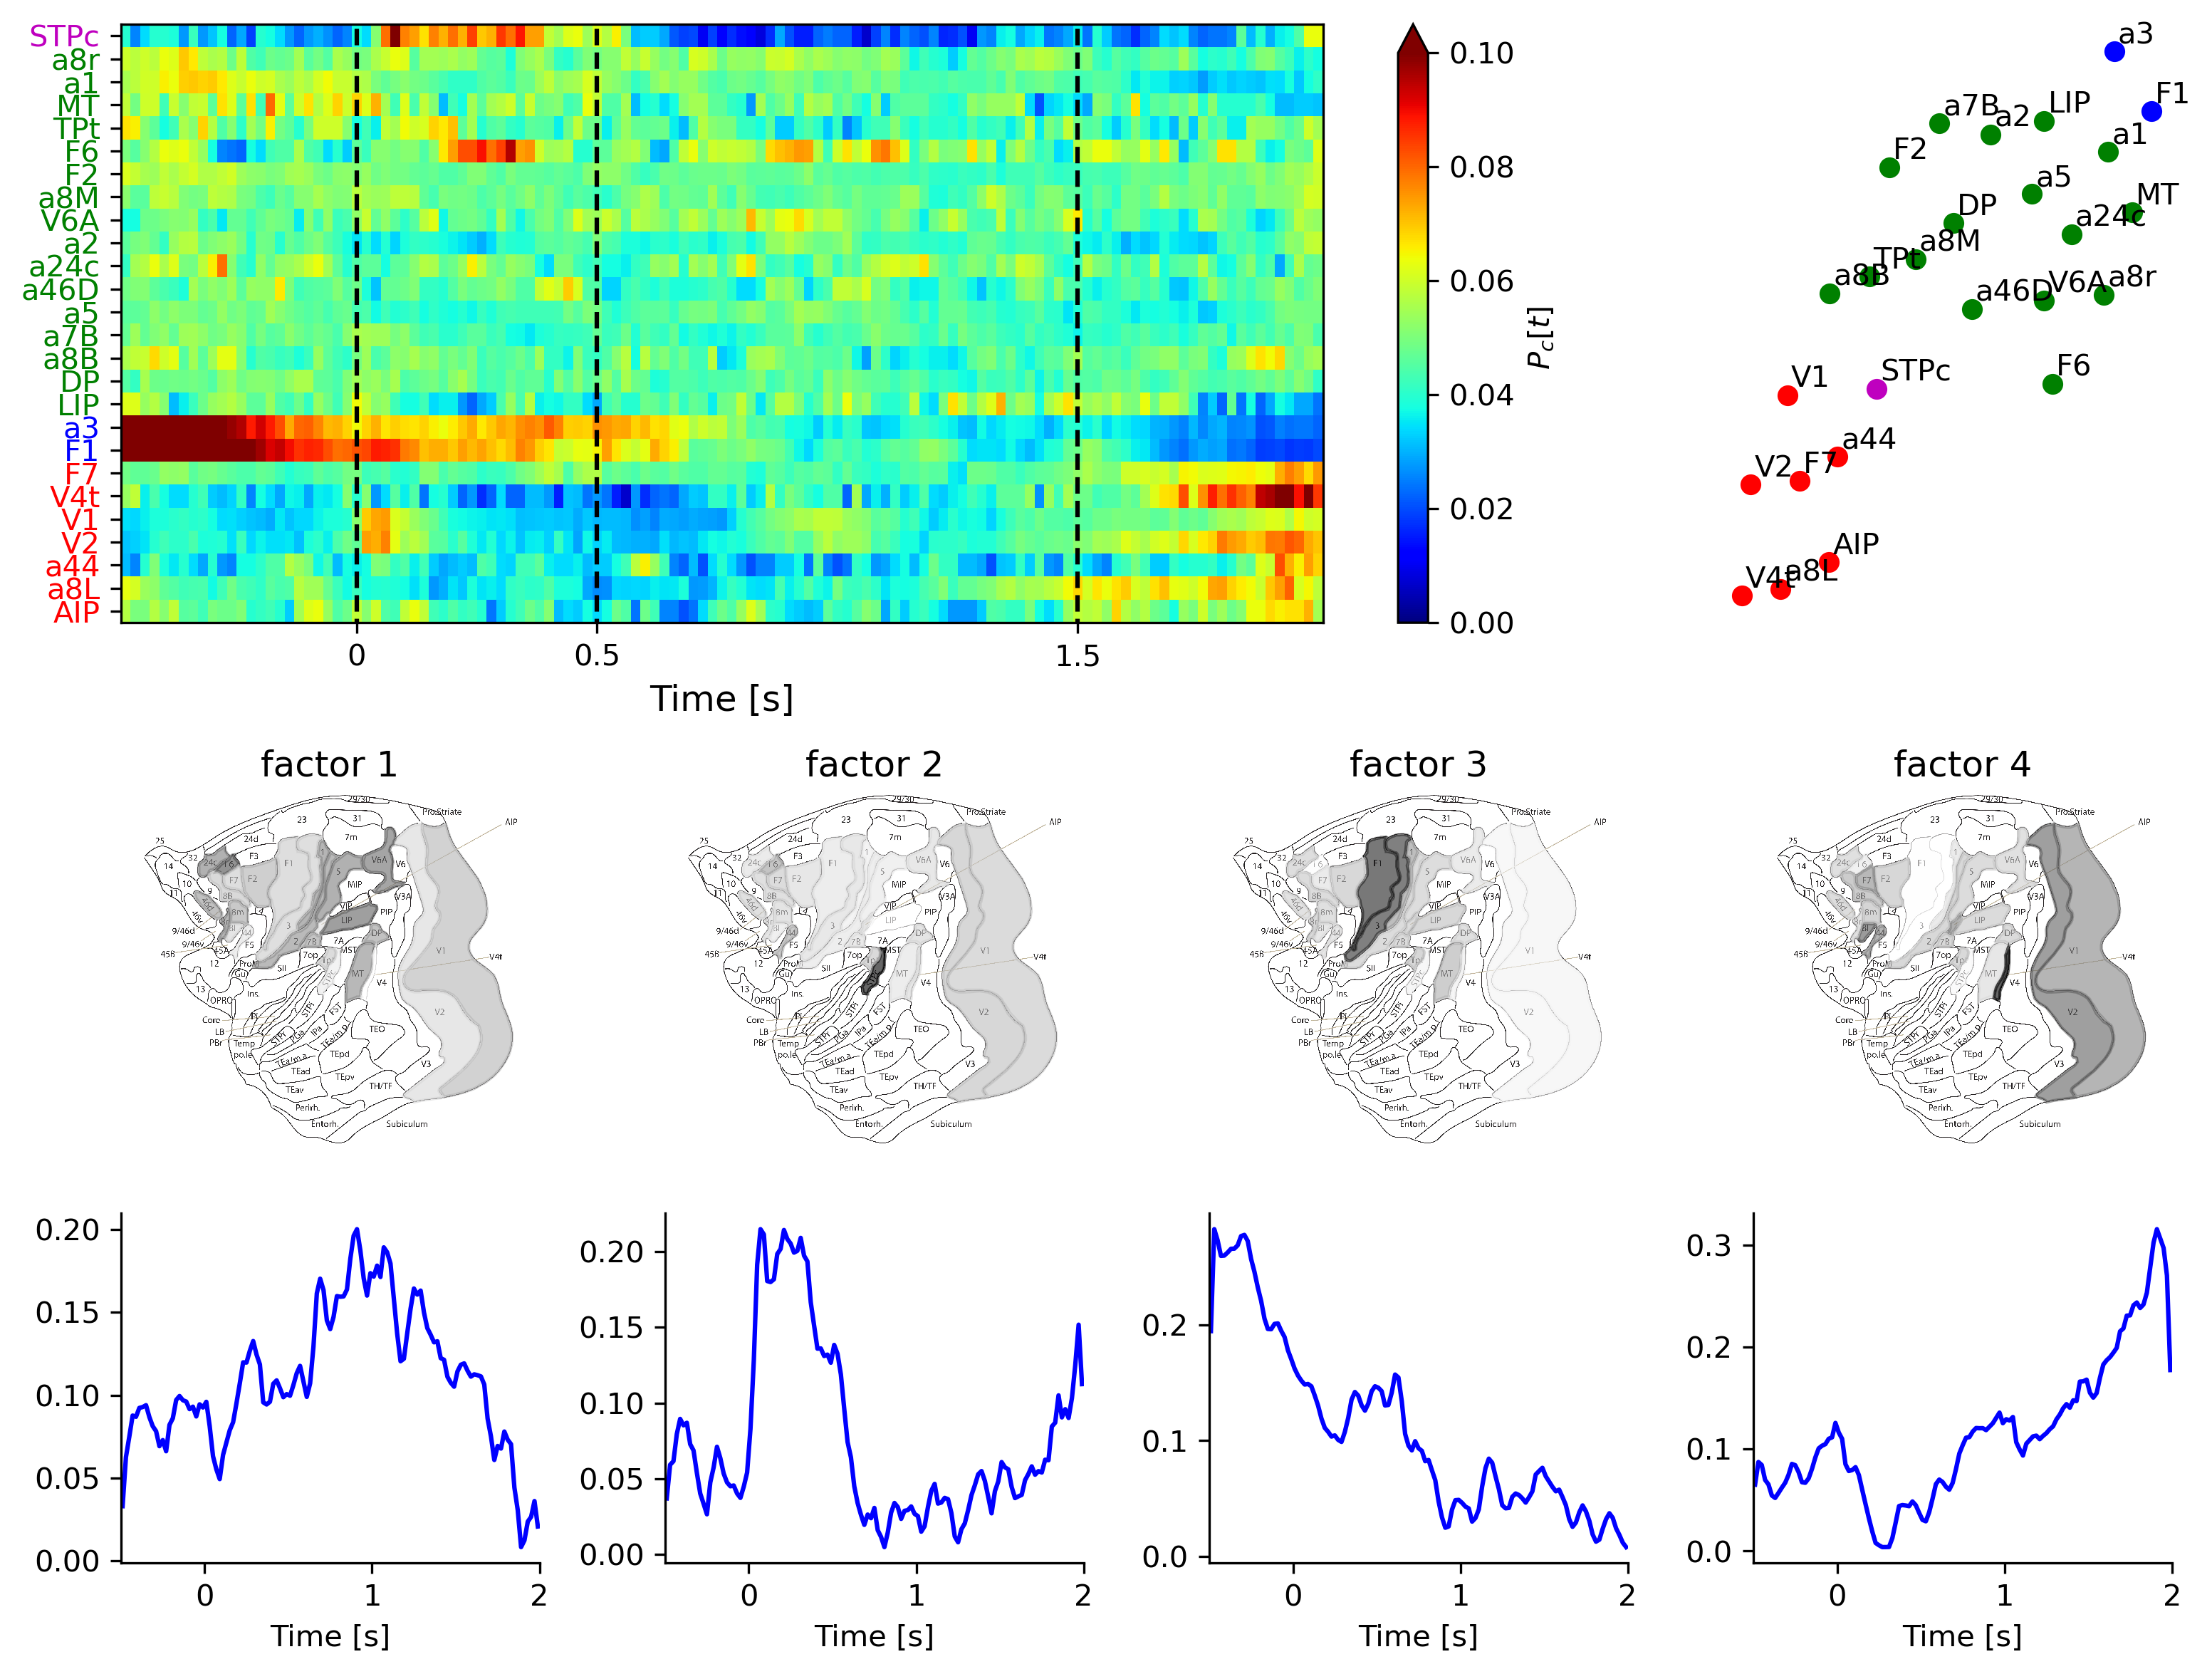

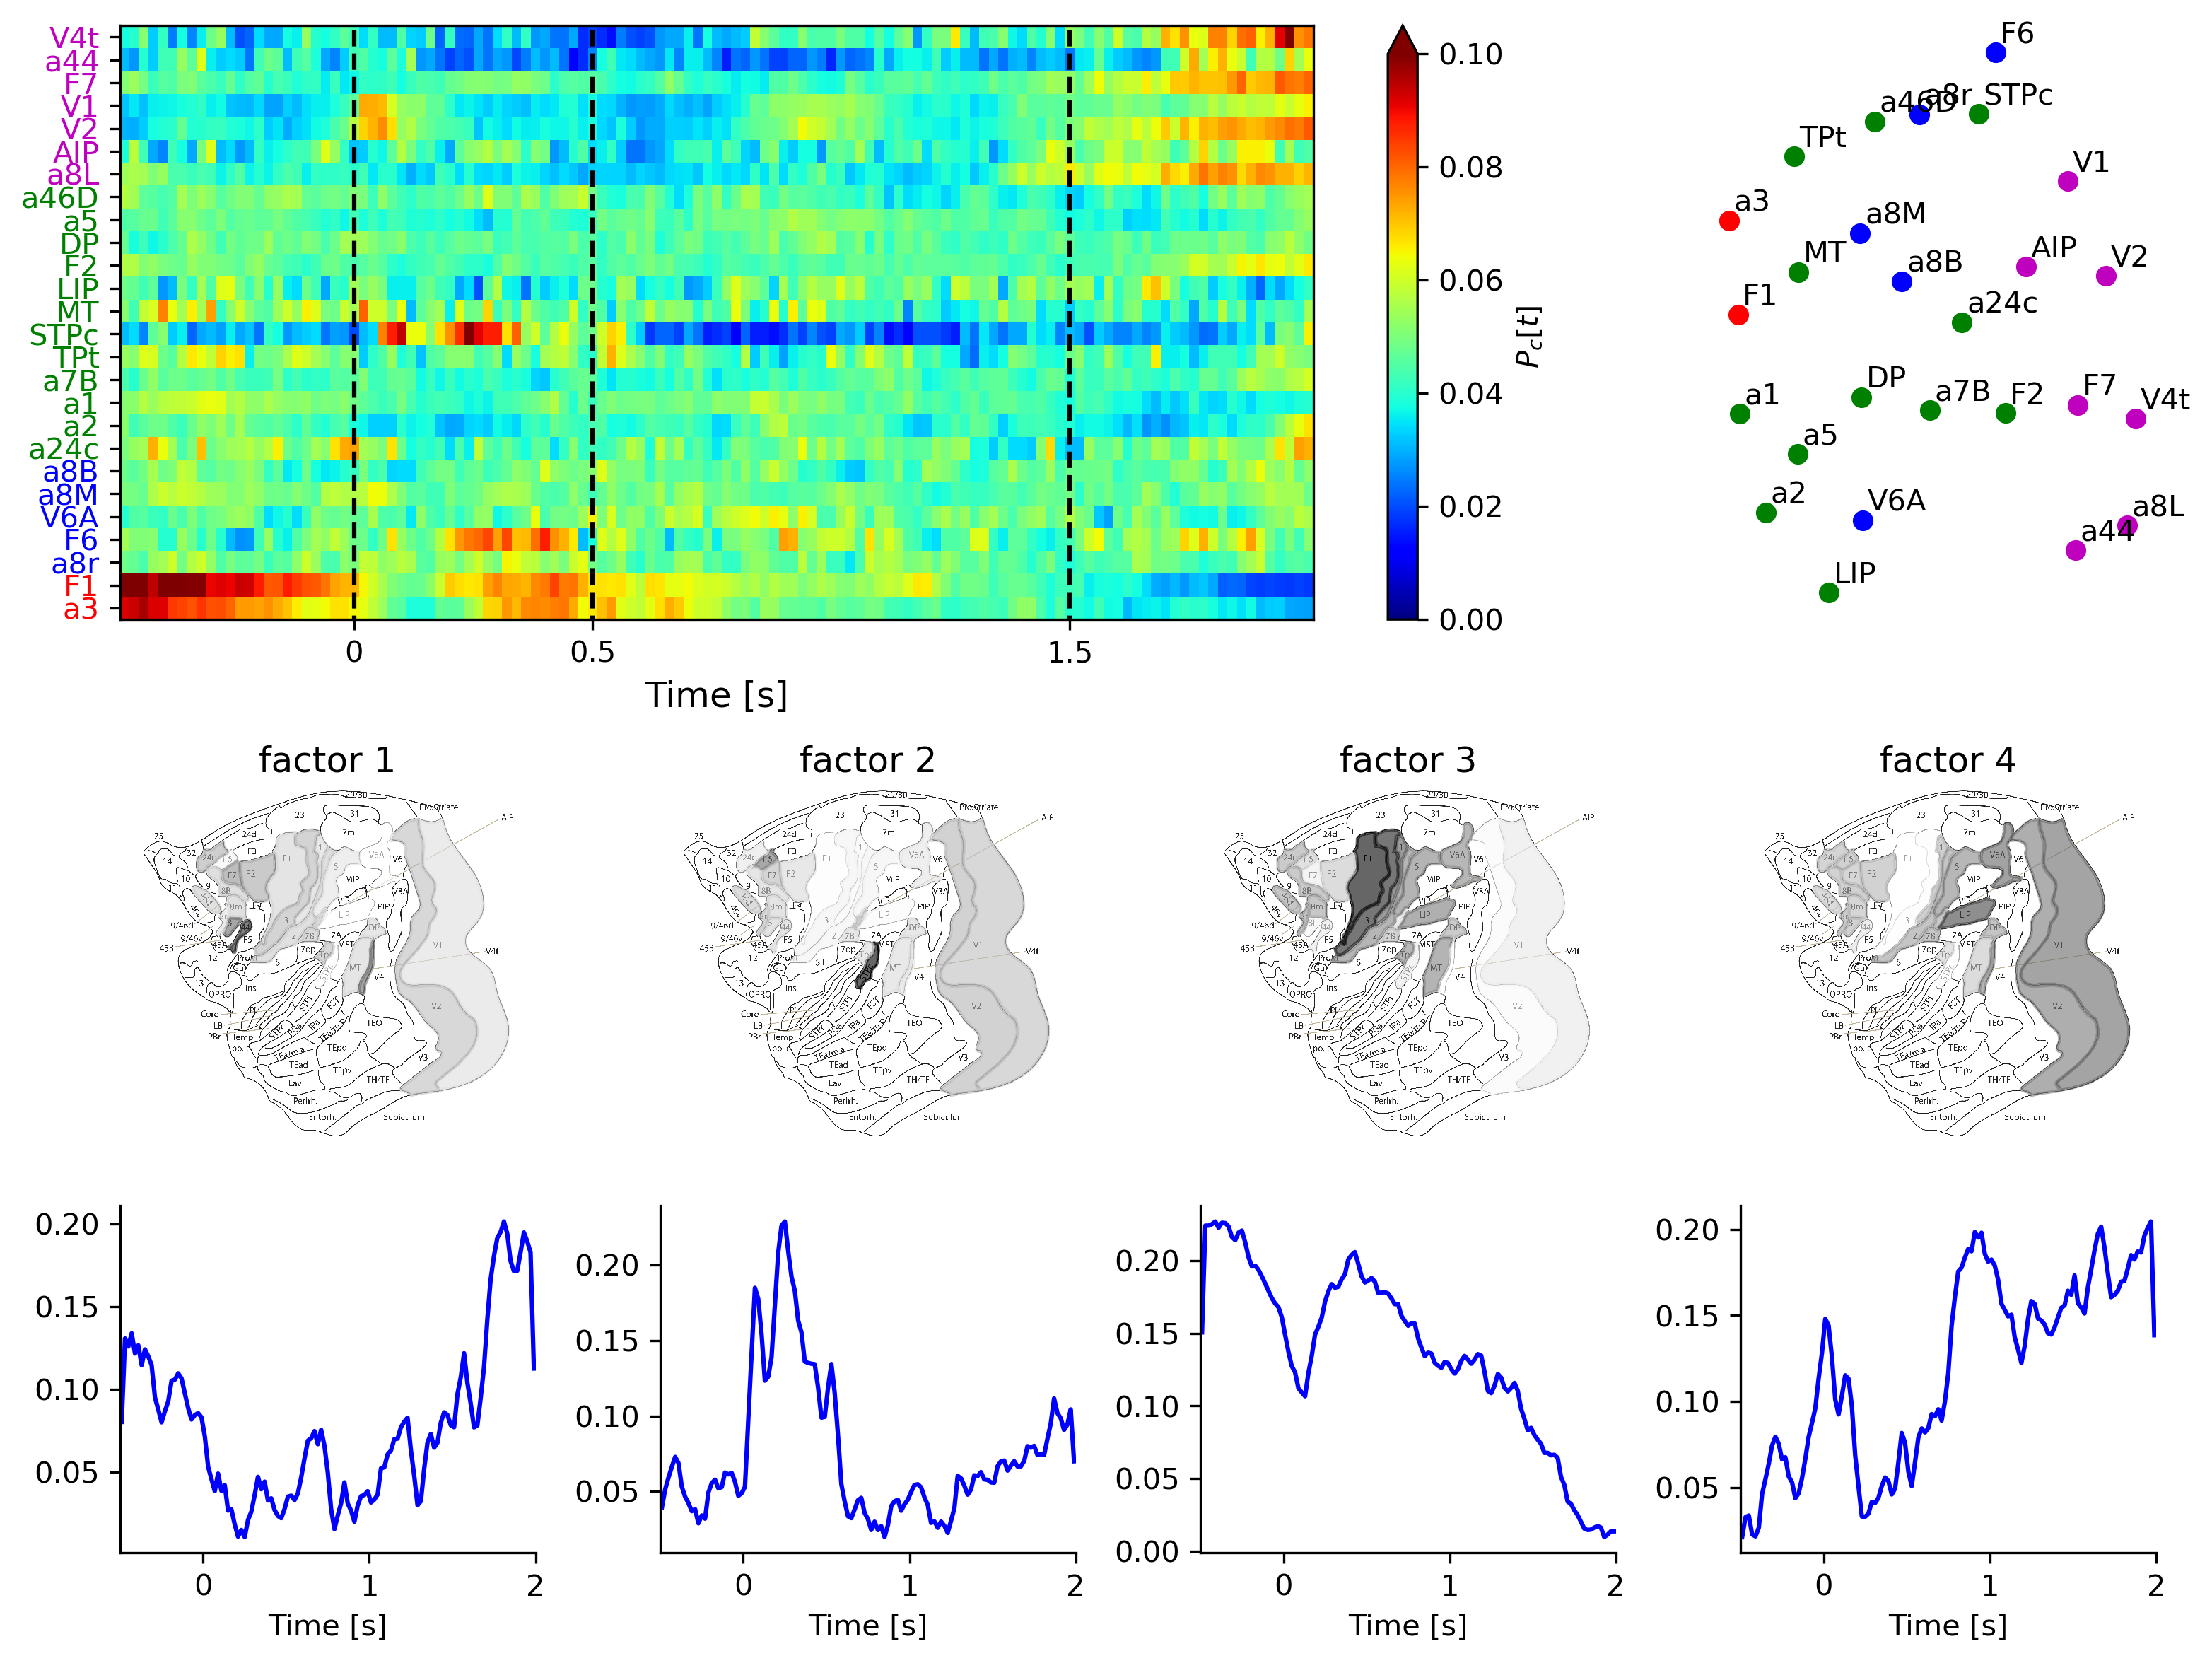

In [178]:
for ii, freq in enumerate(power_task.freqs.data):

    fig = plt.figure(figsize=(16, 8), dpi=300)

    gs0 = fig.add_gridspec(
        nrows=1,
        ncols=2,
        left=0.05,
        right=0.65,
        wspace=0.1,
        bottom=0.6,
        top=0.95,
        width_ratios=(1.0, 0.3),
    )

    gs1 = fig.add_gridspec(
        nrows=2,
        ncols=4,
        left=0.05,
        right=0.65,
        wspace=0.3,
        bottom=0.05,
        top=0.5,
        height_ratios=(0.5, 0.5),
    )

    # Prob. burst
    ax1 = plt.subplot(gs0[0])
    plot_rate_probability(
        P_b_task.sel(freqs=freq).median("boot"),
        labels_task.sel(freqs=freq),
        ax1,
        vmax=vmax[ii],
        cmap="jet",
    )

    # Embedding
    ax2 = plt.subplot(gs0[1])
    plot_embedding(W_task.sel(freqs=freq), labels_task.sel(freqs=freq), ax2, names=True)

    # Factors
    for i in range(4):
        ax = plt.subplot(gs1[i])
        values = norm.sel(freqs=freq, components=i)
        areas = [a.lower() for a in values.roi.data]
        fmap = flatmap(values.data, areas)

        # Only plot colorbar for last column
        fmap.plot(
            ax,
            ax_colorbar=None,
            cbar_title="Norm. entropy",
            alpha=0.6,
            vmin=0,
            vmax=0.7,
            colormap="Greys",
        )
        plt.title(f"factor {i + 1}")
    # Factors
    for i in range(4, 8):
        ax = plt.subplot(gs1[i])
        plt.plot(H_task.times, H_task.sel(freqs=freq, components=i - 4), color="b")
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.xlim([-0.5, 2])
        plt.xlabel("Time [s]")

    plt.savefig(f"figures/n2/burst_prob_{freq}.pdf", bbox_inches="tight")

In [22]:
m = P_b_task.median("boot")
lb = P_b_task_stim.quantile(0.05, "boot")
ub = P_b_task_stim.quantile(0.95, "boot")

In [23]:
regions = np.array([get_areas()[roi.lower()] for roi in m.roi.data])
idx = np.argsort(regions)

In [24]:
RMIt = (m < lb).astype(int) + (m > ub)

In [25]:
RMI = []
for pos, (t_0, t_1) in enumerate(stages):
    RMI += [RMIt.sel(times=slice(t_0, t_1)).mean("times").mean("stim")]
RMI = xr.concat(RMI, "times")

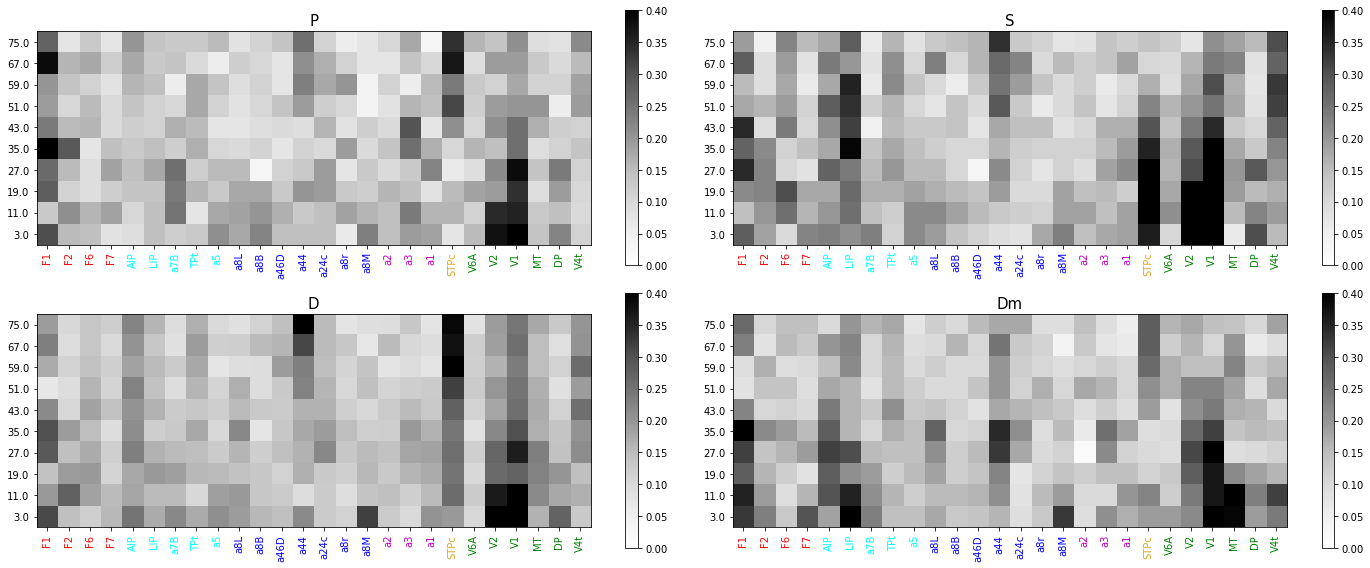

In [26]:
plt.figure(figsize=(20, 8))
titles = ["P", "S", "D", "Dm"]
for pos, (t_0, t_1) in enumerate(stages):

    plt.subplot(2, 2, pos + 1)

    plt.imshow(
        RMI.isel(times=pos).T[:, idx],
        vmin=0,
        vmax=0.4,
        origin="lower",
        cmap="Greys",
    )
    plt.yticks(range(10), m.freqs.data)
    tks = plt.xticks(range(m.sizes["roi"]), m.roi.data[idx], rotation=90)
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.title(f"{titles[pos]}", fontsize=15)
    plt.colorbar()
plt.tight_layout()

In [27]:
m = P_b_task.median("boot")
lb = P_b_fix.quantile(0.05, "boot")
ub = P_b_fix.quantile(0.95, "boot")

In [28]:
RMIt = (m < lb).astype(int) + (m > ub)

RMI = []
for pos, (t_0, t_1) in enumerate(stages):
    RMI += [RMIt.sel(times=slice(t_0, t_1)).mean("times")]
RMI = xr.concat(RMI, "times")

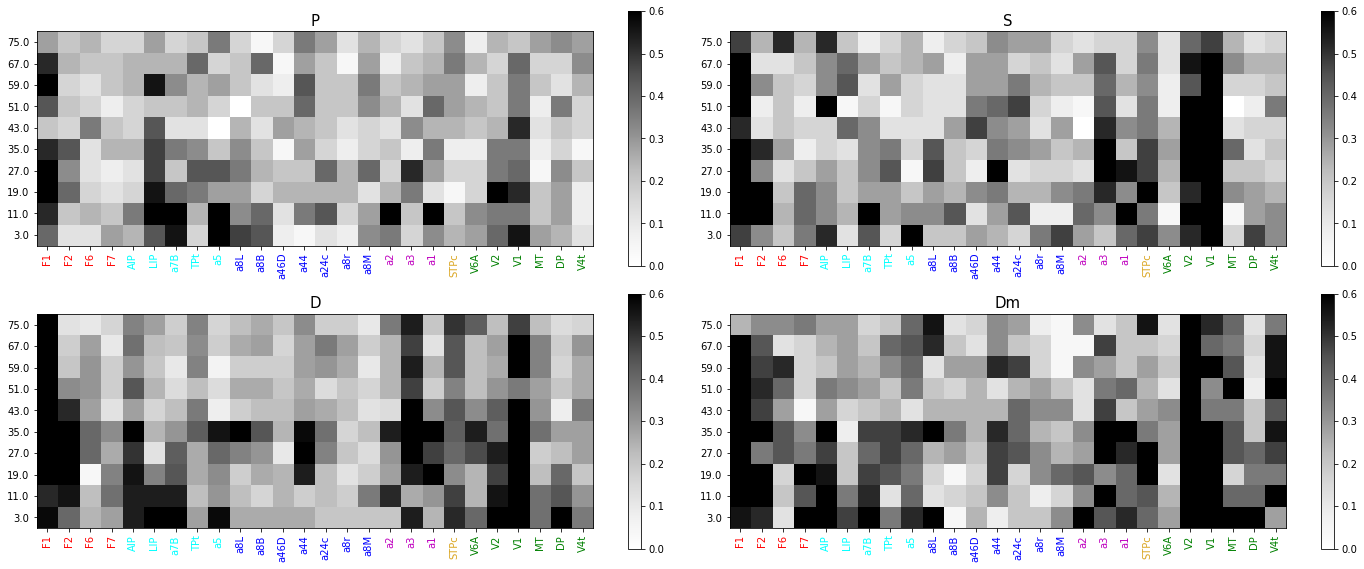

In [29]:
plt.figure(figsize=(20, 8))
titles = ["P", "S", "D", "Dm"]
for pos, (t_0, t_1) in enumerate(stages):

    plt.subplot(2, 2, pos + 1)

    plt.imshow(
        RMI.isel(times=pos).T[:, idx],
        vmin=0,
        vmax=0.6,
        origin="lower",
        cmap="Greys",
    )
    plt.yticks(range(10), m.freqs.data)
    tks = plt.xticks(range(m.sizes["roi"]), m.roi.data[idx], rotation=90)
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.title(f"{titles[pos]}", fontsize=15)
    plt.colorbar()
plt.tight_layout()

In [30]:
pairs = np.stack(np.triu_indices(10, k=1), 1)

In [31]:
freqs = P_b_task.freqs.data.astype(int)
rois = P_b_task.roi.data

In [32]:
nrois, nfreqs, nboot, ntimes = [P_b_task.sizes[key] for key in P_b_task.sizes.keys()]

In [33]:
P_b_task.coords.keys()

KeysView(Coordinates:
  * times    (times) float64 -0.49 -0.47 -0.45 -0.43 ... 1.93 1.95 1.97 1.99
  * freqs    (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
  * roi      (roi) object 'AIP' 'DP' 'F1' 'F2' 'F6' ... 'a8B' 'a8L' 'a8M' 'a8r')

In [34]:
import numba as nb


def return_crossband_cc(burst_probs):
    """
    Calculate cross-frequency correlation coefficient between all pairs of ROIs,
    at different frequency bands of a given burst_probs.

    Parameters
    ----------
    burst_probs : xr.DataArray
        A 4D array with dimensions ("roi", "freqs", "boot", "times").
        Should contain probability of bursts of activity at different frequency bands,
        for different regions of interest (ROIs) and different time points.

    Returns
    -------
    mat : xr.DataArray
        A 3D array with dimensions ("sources", "targets", "freqs"),
        containing the cross-frequency correlation coefficient between all pairs of ROIs.
    """
    np.testing.assert_array_equal(burst_probs.dims, ("roi", "freqs", "boot", "times"))

    nrois, nfreqs, nboot, ntimes = [
        burst_probs.sizes[key] for key in burst_probs.sizes.keys()
    ]

    times, freqs, rois = [
        burst_probs.coords[key].data for key in burst_probs.coords.keys()
    ]

    freqs = freqs.astype(int)

    # Pairs of frequencies
    pairs = np.stack(np.triu_indices(nfreqs, k=1), 1)
    # Number of pairs
    n_xf = len(pairs)

    burst_probs = burst_probs.median("boot").data

    @nb.njit
    def _for_freq():
        mat = np.zeros((nrois, nrois, n_xf))
        nf = 0
        for i, j in pairs:
            mat[..., nf] = np.corrcoef(
                burst_probs[:, i],
                burst_probs[:, j],
            )[0:nrois, nrois : 2 * nrois]
            nf = nf + 1
        return mat

    mat = _for_freq()

    # Cross-frequency coordinates
    xf = [f"{freqs[i]}-{freqs[j]}" for i, j in pairs]

    mat = xr.DataArray(
        mat, dims=("sources", "targets", "freqs"), coords=(rois, rois, xf)
    )
    return mat

In [35]:
mat = [return_crossband_cc(P_b_task.isel(boot=[i])) for i in tqdm(range(100))]

100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


In [36]:
mat_fix = [return_crossband_cc(P_b_fix.isel(boot=[i])) for i in tqdm(range(100))]

100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


In [37]:
mat = xr.concat(mat, "boot")

In [38]:
mat_fix = xr.concat(mat_fix, "boot")

In [39]:
_, pvals = stats.ttest_ind(mat_fix, mat, axis=0)

In [40]:
out = mat.median("boot") * (pvals <= 0.0001)
out = (out + out.transpose("targets", "sources", "freqs")) / 2

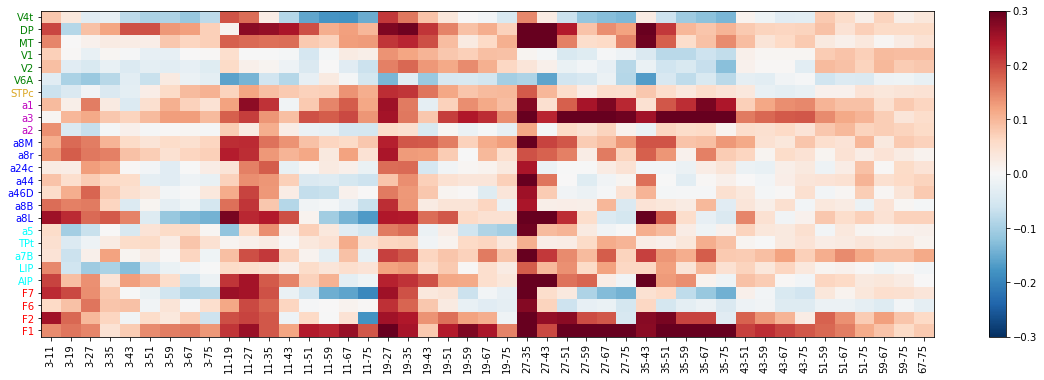

In [41]:
plt.figure(figsize=(20, 6))
plt.imshow(
    out.mean(axis=0)[idx],
    aspect="auto",
    cmap="RdBu_r",
    origin="lower",
    vmin=-0.3,
    vmax=0.3,
)
plt.xticks(
    range(mat.sizes["freqs"]),
    mat.freqs.data,
    rotation=90,
)
tks = plt.yticks(range(mat.sizes["sources"]), rois[idx])
[tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
plt.colorbar()

#### All sessions

In [29]:
data_loader = loader(_ROOT=_ROOT)

In [53]:
P_b = []
for session in tqdm(sessions):
    P_b += [data_loader.load_burst_prob(
        session=session, trial_type=1, aligned_at="cue", monkey="lucy", conditional=False
    ).median("boot")]

100%|██████████| 62/62 [00:03<00:00, 18.74it/s]


In [54]:
P_b = data_loader.apply_min_rois(P_b, min_rois=10)

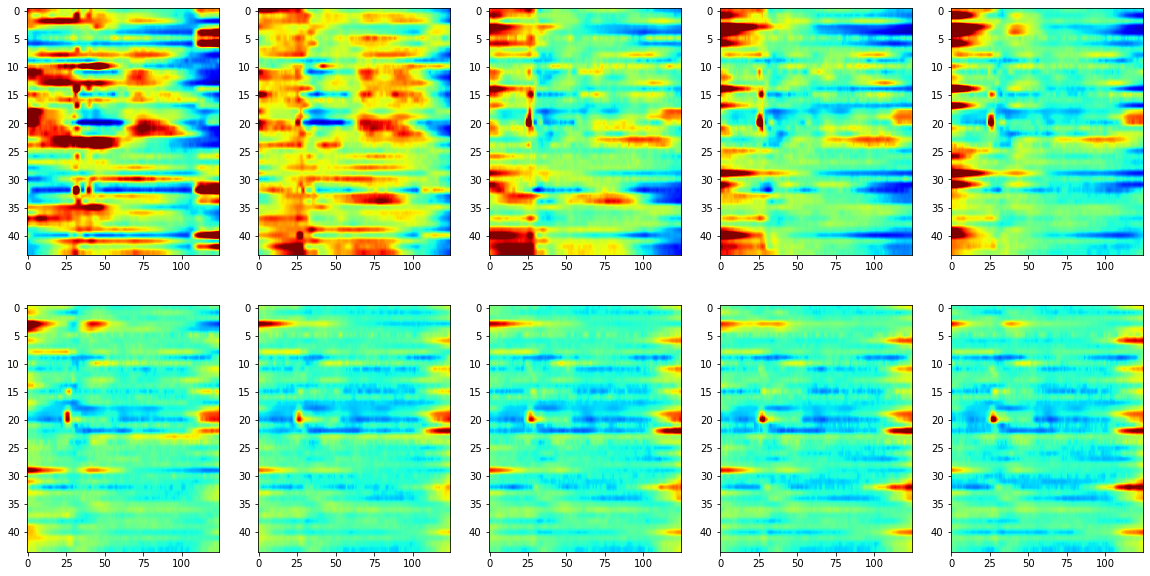

In [55]:
plt.figure(figsize=(20, 10))
for pos, freq in enumerate(P_b.freqs.data):
    plt.subplot(2, 5, pos + 1)
    plt.imshow(
        P_b.sel(freqs=freq), vmin=0, vmax=0.1, cmap="jet", aspect="auto"
    )

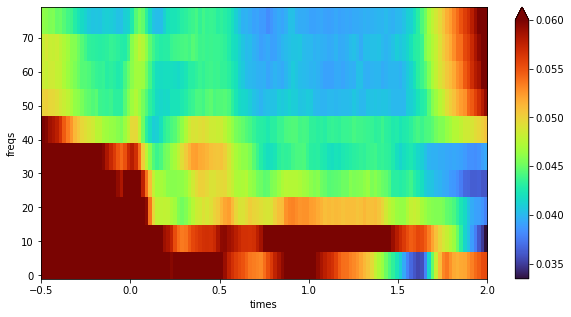

In [56]:
plt.figure(figsize=(10, 5))

P_b.mean("roi").plot.imshow( vmax=0.06, cmap="turbo")